# **Unsupervised Learning** 

In [247]:
import pandas as pd
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tabulate import tabulate

from sklearn.decomposition import KernelPCA

import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.cluster import AgglomerativeClustering

from sklearn.manifold import TSNE
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")

In [248]:
df_o = pd.read_excel('data_after_EDA.xlsx')

In [249]:
df = df_o.copy()

________________________________________________________________

# Handling Categorical and Numerical Columns

In this step, we separated the numerical columns from the categorical columns. The categorical columns were analyzed based on our judgment to determine their relevance for later analysis. Columns deemed relevant were processed with one-hot encoding, while the others were removed from the dataset.

The categorical columns we chose to focus on are:

* authority_status: The type of authority (regional or local council).
* general_district: The district of the settlement.
* Settlement Religion: The religion associated with the settlement.

In [250]:
def classify_columns(df, unique_threshold=10):
    """
    Classifies the columns of a DataFrame into numeric and categorical,
    handling cases where numeric columns may be categorical in nature.
    """
    # Initialize lists for numeric and categorical columns
    numeric_cols = []
    categorical_cols = []

    # Iterate through each column in the DataFrame
    for col in df.columns:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check the number of unique values in the column
            unique_values = df[col].nunique()
            if unique_values <= unique_threshold:
                # Treat as categorical if the number of unique values is below the threshold
                categorical_cols.append(col)
            else:
                # Otherwise, treat as numeric
                numeric_cols.append(col)
        else:
            # If the column is not numeric, classify as categorical
            categorical_cols.append(col)

    # Create a dictionary to store the results
    classification_result = {
        'Numeric_Columns': numeric_cols,
        'Categorical_Columns': categorical_cols
    }

    return classification_result

In [251]:
# Classify the columns
result = classify_columns(df)

# Get the list of categorical columns
categorical_columns = result['Categorical_Columns']

# Drop the categorical columns
#df_1 = df.drop(columns=categorical_columns)

# Display the remaining numeric columns
print("catgorical columns:",categorical_columns)
df[categorical_columns]

catgorical columns: ['auth_name', 'authority_status', 'arnona_area_solar_ground', 'arnona_area_solar_land', 'arnona_charge_residential_unused', 'arnona_charge_solar_ground', 'arnona_charge_solar_land', 'general_district', 'general_municipal_status', 'general_coastal', 'transport_accidents_fatal', 'transport_casualties_fatal', 'socio_cluster_2015', 'periph_cluster', 'region_settle_urban_jewish_5k_10k', 'region_settle_urban_nonjewish_5k_10k', 'region_settle_urban_jewish_2k_5k', 'region_settle_urban_moshav_2k_5k', 'region_settle_urban_moshav_collective_2k_5k', 'region_settle_urban_kibbutz_2k_5k', 'region_settle_urban_nonjewish_2k_5k', 'region_settle_moshav_collective', 'region_settle_institutional_jewish', 'region_settle_institutional_nonjewish', 'region_settle_community', 'region_settle_rural_other_jewish', 'settlements_rural_other_non_jewish', 'District', 'Settlement Religion', 'English Settlement Name']


,auth_name,authority_status,arnona_area_solar_ground,arnona_area_solar_land,arnona_charge_residential_unused,arnona_charge_solar_ground,arnona_charge_solar_land,general_district,general_municipal_status,general_coastal,...,region_settle_urban_nonjewish_2k_5k,region_settle_moshav_collective,region_settle_institutional_jewish,region_settle_institutional_nonjewish,region_settle_community,region_settle_rural_other_jewish,settlements_rural_other_non_jewish,District,Settlement Religion,English Settlement Name
0,הגליל העליון,מועצה אזורית,0,0.0,0,0,0,הצפון,מועצה אזורית,0,...,0,0,0,0,0,0,0,3,1,Upper Galilee
1,מרום הגליל,מועצה אזורית,0,0.0,0,0,0,הצפון,מועצה אזורית,0,...,0,1,0,0,4,1,2,3,1,Merom HaGalil
2,הגליל התחתון,מועצה אזורית,0,0.0,0,0,0,הצפון,מועצה אזורית,0,...,0,1,2,0,3,1,0,3,1,Lower Galilee
3,מטה אשר,מועצה אזורית,0,0.0,0,0,0,הצפון,מועצה אזורית,1,...,1,2,0,0,2,1,1,3,1,Mateh Asher
4,עמק הירדן,מועצה אזורית,0,0.0,0,0,0,הצפון,מועצה אזורית,0,...,0,0,0,0,0,4,0,3,1,Jordan Valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,יהוד,עיריה,0,0.0,0,0,0,המרכז,עירייה,0,...,0,0,0,0,0,0,0,4,1,Yehud
251,קריית ביאליק,עיריה,0,0.0,0,0,0,חיפה,עירייה,0,...,0,0,0,0,0,0,0,3,1,Qiryat Bialik
252,קריית ים,עיריה,0,0.0,0,0,0,חיפה,עירייה,1,...,0,0,0,0,0,0,0,3,1,Qiryat Yam
253,הוד השרון,עיריה,0,0.0,0,0,0,המרכז,עירייה,0,...,0,0,0,0,0,0,0,4,1,Hod HaSharon


In [252]:
Categoricals_columns= ['auth_name', 'arnona_area_solar_ground',
                            'arnona_area_solar_land', 'arnona_charge_residential_unused', 'arnona_charge_solar_ground',
                            'arnona_charge_solar_land', 'general_municipal_status', 'general_coastal',
                            'transport_accidents_fatal', 'transport_casualties_fatal', 'socio_cluster_2015', 'periph_cluster',
                            'region_settle_urban_jewish_5k_10k', 'region_settle_urban_nonjewish_5k_10k', 'region_settle_urban_jewish_2k_5k',
                            'region_settle_urban_moshav_2k_5k', 'region_settle_urban_moshav_collective_2k_5k', 'region_settle_urban_kibbutz_2k_5k',
                            'region_settle_urban_nonjewish_2k_5k', 'region_settle_moshav_collective', 'region_settle_institutional_jewish', 'region_settle_institutional_nonjewish',
                            'region_settle_community', 'region_settle_rural_other_jewish', 'settlements_rural_other_non_jewish',
                            'District', 'English Settlement Name']
columns_to_encode = ['authority_status', 'general_district', 'Settlement Religion']


one-hot encoding

In [253]:
def process_columns(df, columns_to_encode):
    # Create one-hot encoding for specified columns
    encoded_data = pd.get_dummies(df[columns_to_encode], drop_first=True).astype(int)  # Ensure numeric encoding

    # Get all numeric columns except those in categorical_columns list
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    remaining_numeric_columns = [col for col in numeric_columns if col not in Categoricals_columns]

    # Remove the encoded columns from the original dataframe
    df_cleaned = df.drop(columns=columns_to_encode)

    return encoded_data, df_cleaned, remaining_numeric_columns

# Example usage:
encoded_df, cleaned_df, numeric_cols = process_columns(df, columns_to_encode)

# Check the data types of the encoded DataFrame
print(encoded_df.dtypes)  # All columns should now be integers

Settlement Religion              int64
authority_status_מועצה מקומית    int64
authority_status_עיריה           int64
general_district_הדרום           int64
general_district_המרכז           int64
general_district_הצפון           int64
general_district_חיפה            int64
general_district_ירושלים         int64
general_district_תל אביב         int64
dtype: object


In [254]:
columns_to_remove = Categoricals_columns + columns_to_encode

# removing columns
df_1 = df.drop(columns=columns_to_remove, errors='ignore')

________________________

#Data Preparation: Splitting the Dataset by Topics


The dataset is a large DataFrame containing various topics such as economics, welfare, and additional data related to cities in Israel. Initial attempts to reduce dimensionality using PCA were not effective due to the diverse nature of the categories within the dataset. To address this, we decided to split the dataset into multiple DataFrames based on the number of subtopics, resulting in 22 distinct DataFrames.

In [255]:
def group_columns_by_prefix_lists(df):
    """
    Creates groups of columns based on their prefixes
    """
    # List of all columns
    all_columns = df.columns

    # Create dictionary where key is prefix and value is list of columns
    prefix_groups = defaultdict(list)
    singles = []

    for col in all_columns:
        parts = col.split('_')
        if len(parts) > 1:
            prefix = parts[0]
            # Check how many columns share this prefix
            related_cols = [c for c in all_columns if c.startswith(prefix + '_')]
            if len(related_cols) > 1:
                prefix_groups[prefix].extend([col])
            else:
                singles.append(col)
        else:
            singles.append(col)

    # Convert dictionary to list of lists and sort
    grouped_columns = list(prefix_groups.values())
    if singles:  # If there are single columns, add them as a separate group
        grouped_columns.append(singles)

    return grouped_columns #lists

# Create groups
column_groups = group_columns_by_prefix_lists(df_1)
len(column_groups)

22

In [256]:
def get_column_groups(columns):
    """
    Creates groups of columns based on their prefixes and returns both groups and group names
    """

    # Create dictionary where key is prefix and value is list of columns
    prefix_groups = defaultdict(list)
    singles = []

    for col in columns:
        parts = col.split('_')
        if len(parts) > 1:
            prefix = parts[0]
            # Check how many columns share this prefix
            related_cols = [c for c in columns if c.startswith(prefix + '_')]
            if len(related_cols) > 1:
                prefix_groups[prefix].append(col)
            else:
                singles.append(col)
        else:
            singles.append(col)

    # Add singles to their own group if any exist
    if singles:
        prefix_groups['other'] = singles

    # Get sorted list of group names
    group_names = sorted(prefix_groups.keys())

    return prefix_groups, group_names

def create_sub_dataframes(df, save_to_csv=False):
    """
    Creates sub-dataframes based on column prefixes
    """
    # Get column groups and names
    column_groups, group_names = get_column_groups(df.columns)

    # Create dictionary and list to store sub-dataframes
    dataframes_dict = {}
    dataframes_list = []

    # Create sub-dataframes
    for group_name in group_names:
        columns = column_groups[group_name]
        sub_df = df[columns].copy()

        # Add to both dictionary and list
        dataframes_dict[group_name] = sub_df
        dataframes_list.append(sub_df)

        # Optionally save to CSV
        if save_to_csv:
            sub_df.to_csv(f"{group_name}_data.csv", index=False)

    return dataframes_dict, group_names, dataframes_list

def print_group_info(column_groups, group_names):
    """
    Displays information about the created column groups
    """
    print("\nCreated column groups:")
    for i, group_name in enumerate(group_names, 1):
        print(f"\nGroup {i}: {group_name}")
        for col in sorted(column_groups[group_name]):
            print(f"  - {col}")

# Create sub-dataframes and get group names and dataframes list
dfs_dict, group_names, dfs_list = create_sub_dataframes(df)

# Print available groups
print("\nAvailable groups:", group_names)

# Access data using dictionary
budget_df = dfs_dict['budget']
demo_df = dfs_dict['demo']

# Access data using list (same order as group_names)
for i, group_name in enumerate(group_names):
    current_df = dfs_list[i]
    # Process each dataframe here

# You can also iterate through both simultaneously
for group_name, sub_df in zip(group_names, dfs_list):
    print(f"\nShape of {group_name} dataframe:", sub_df.shape)

# If you want to save all sub-dataframes to CSV files:
dfs_dict, group_names, dfs_list = create_sub_dataframes(df_1, save_to_csv=False)


Available groups: ['arnona', 'authority', 'budget', 'compact', 'construction', 'demo', 'edu', 'elect', 'emp', 'employ', 'general', 'health', 'infra', 'land', 'other', 'periph', 'pop', 'region', 'socio', 'transport', 'waste', 'water', 'welfare']

Shape of arnona dataframe: (255, 38)

Shape of authority dataframe: (255, 2)

Shape of budget dataframe: (255, 69)

Shape of compact dataframe: (255, 3)

Shape of construction dataframe: (255, 6)

Shape of demo dataframe: (255, 61)

Shape of edu dataframe: (255, 40)

Shape of elect dataframe: (255, 4)

Shape of emp dataframe: (255, 4)

Shape of employ dataframe: (255, 9)

Shape of general dataframe: (255, 8)

Shape of health dataframe: (255, 5)

Shape of infra dataframe: (255, 9)

Shape of land dataframe: (255, 29)

Shape of other dataframe: (255, 15)

Shape of periph dataframe: (255, 5)

Shape of pop dataframe: (255, 2)

Shape of region dataframe: (255, 17)

Shape of socio dataframe: (255, 3)

Shape of transport dataframe: (255, 10)

Shape of

adding the encoded columns

In [257]:
dfs_list.append(encoded_df)

_________________

#Dimensionality Reduction for Each Dataset Category

In this step, we apply dimensionality reduction using PCA to each DataFrame separately, based on its category. To ensure a fair representation and minimize the influence of outliers, we first normalized the data using standardization.

The PCA transformation was designed to retain at least 90% of the explained variance for each category. After performing PCA on each category-specific DataFrame, we combined the resulting reduced-dimension features into a single new DataFrame. This consolidated DataFrame contains the reduced features from all the different categories, providing a more compact and meaningful representation of the data.

https://www.kaggle.com/code/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering


--- Using Scaler ---


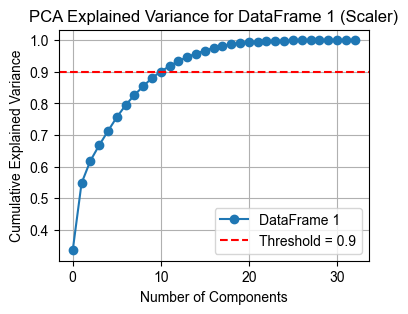

DataFrame 1 (Scaler): Retained 11 components explaining 90.11% of variance.
Original columns: 33, Reduced columns: 11, Non-numeric columns: 0


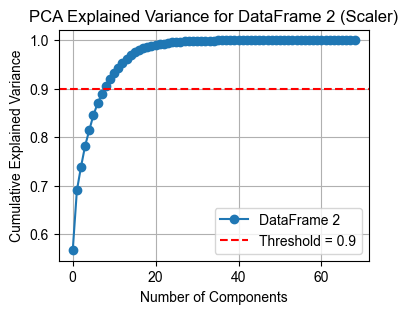

DataFrame 2 (Scaler): Retained 9 components explaining 90.65% of variance.
Original columns: 69, Reduced columns: 9, Non-numeric columns: 0


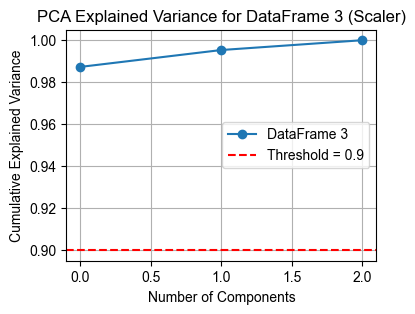

DataFrame 3 (Scaler): Retained 1 components explaining 98.73% of variance.
Original columns: 3, Reduced columns: 1, Non-numeric columns: 0


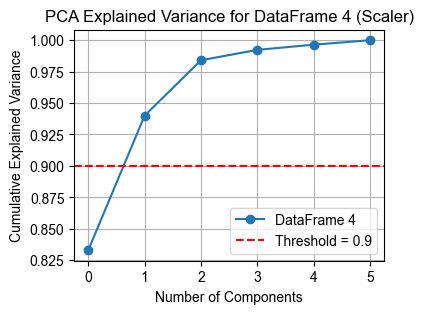

DataFrame 4 (Scaler): Retained 2 components explaining 94.00% of variance.
Original columns: 6, Reduced columns: 2, Non-numeric columns: 0


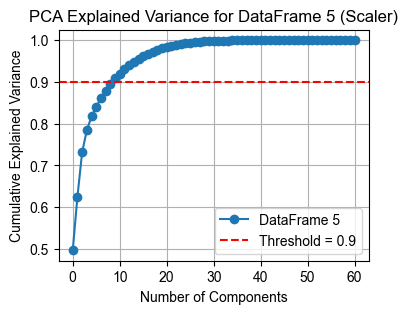

DataFrame 5 (Scaler): Retained 10 components explaining 90.89% of variance.
Original columns: 61, Reduced columns: 10, Non-numeric columns: 0


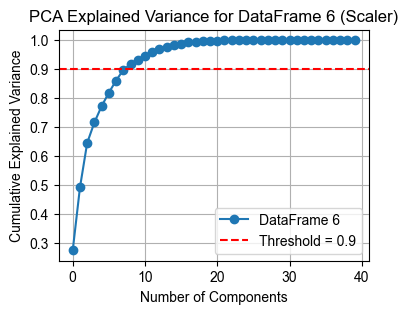

DataFrame 6 (Scaler): Retained 9 components explaining 91.74% of variance.
Original columns: 40, Reduced columns: 9, Non-numeric columns: 0


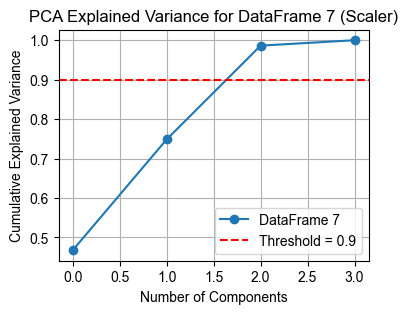

DataFrame 7 (Scaler): Retained 3 components explaining 98.63% of variance.
Original columns: 4, Reduced columns: 3, Non-numeric columns: 0


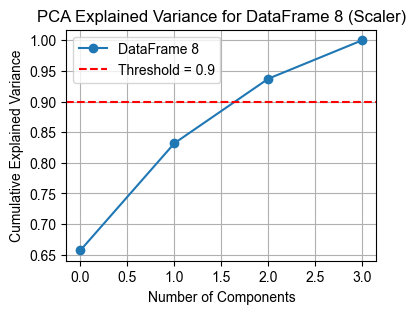

DataFrame 8 (Scaler): Retained 3 components explaining 93.73% of variance.
Original columns: 4, Reduced columns: 3, Non-numeric columns: 0


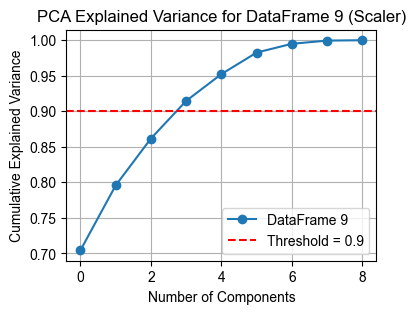

DataFrame 9 (Scaler): Retained 4 components explaining 91.46% of variance.
Original columns: 9, Reduced columns: 4, Non-numeric columns: 0


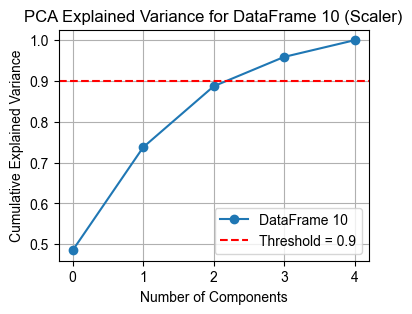

DataFrame 10 (Scaler): Retained 4 components explaining 95.91% of variance.
Original columns: 5, Reduced columns: 4, Non-numeric columns: 0


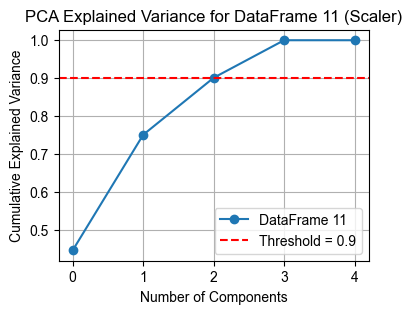

DataFrame 11 (Scaler): Retained 3 components explaining 90.08% of variance.
Original columns: 5, Reduced columns: 3, Non-numeric columns: 0


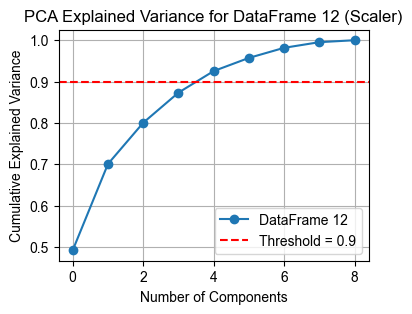

DataFrame 12 (Scaler): Retained 5 components explaining 92.54% of variance.
Original columns: 9, Reduced columns: 5, Non-numeric columns: 0


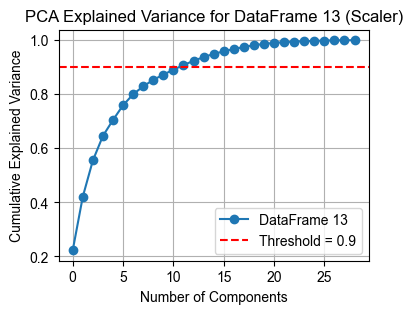

DataFrame 13 (Scaler): Retained 12 components explaining 90.79% of variance.
Original columns: 29, Reduced columns: 12, Non-numeric columns: 0


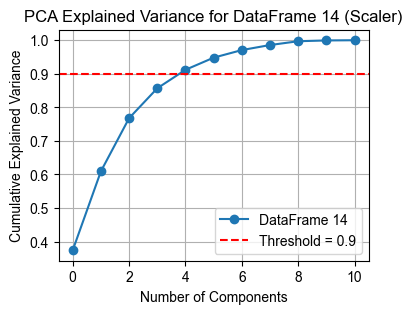

DataFrame 14 (Scaler): Retained 5 components explaining 91.19% of variance.
Original columns: 11, Reduced columns: 5, Non-numeric columns: 0


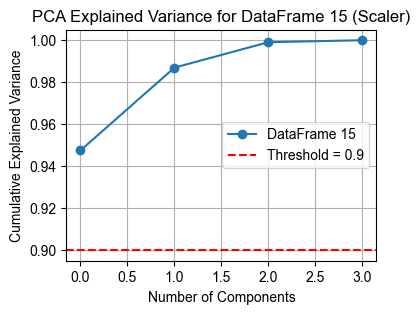

DataFrame 15 (Scaler): Retained 1 components explaining 94.75% of variance.
Original columns: 4, Reduced columns: 1, Non-numeric columns: 0


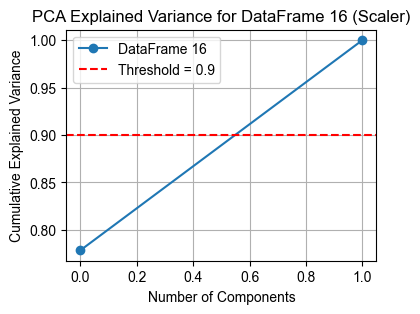

DataFrame 16 (Scaler): Retained 2 components explaining 100.00% of variance.
Original columns: 2, Reduced columns: 2, Non-numeric columns: 0


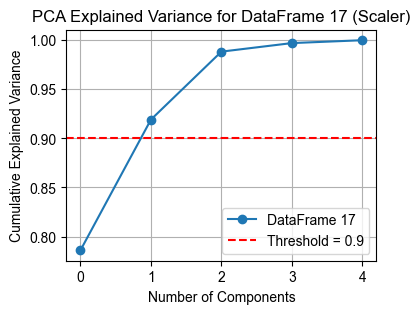

DataFrame 17 (Scaler): Retained 2 components explaining 91.92% of variance.
Original columns: 5, Reduced columns: 2, Non-numeric columns: 0


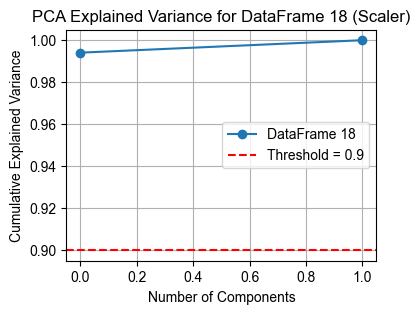

DataFrame 18 (Scaler): Retained 1 components explaining 99.41% of variance.
Original columns: 2, Reduced columns: 1, Non-numeric columns: 0


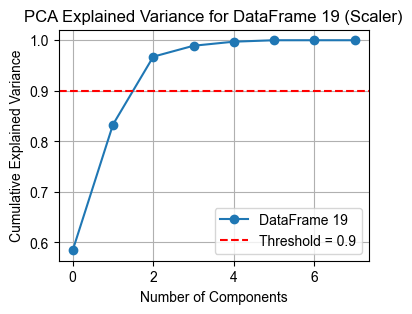

DataFrame 19 (Scaler): Retained 3 components explaining 96.75% of variance.
Original columns: 8, Reduced columns: 3, Non-numeric columns: 0


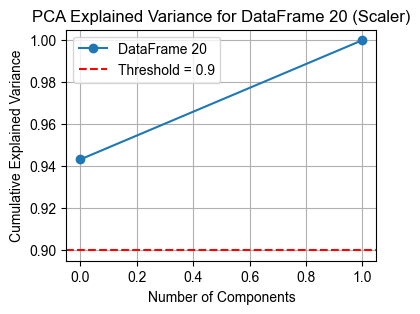

DataFrame 20 (Scaler): Retained 1 components explaining 94.33% of variance.
Original columns: 2, Reduced columns: 1, Non-numeric columns: 0


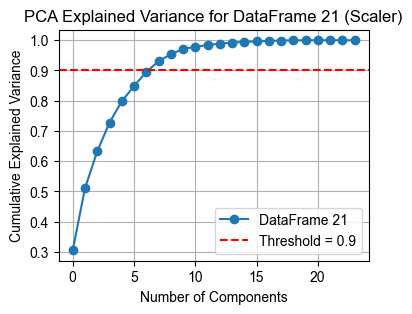

DataFrame 21 (Scaler): Retained 8 components explaining 93.04% of variance.
Original columns: 24, Reduced columns: 8, Non-numeric columns: 0


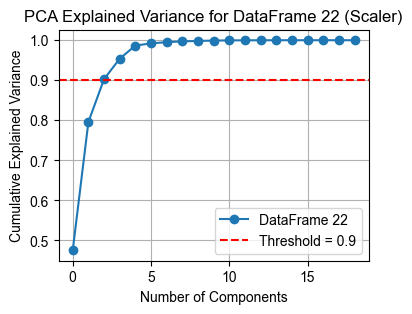

DataFrame 22 (Scaler): Retained 3 components explaining 90.28% of variance.
Original columns: 19, Reduced columns: 3, Non-numeric columns: 0


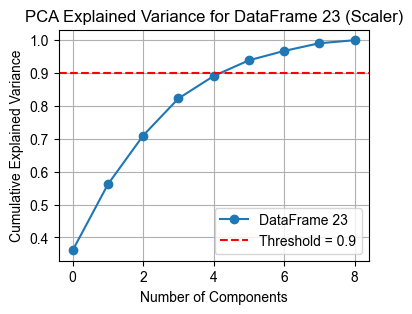

DataFrame 23 (Scaler): Retained 6 components explaining 93.88% of variance.
Original columns: 9, Reduced columns: 6, Non-numeric columns: 0


In [258]:
def perform_pca_and_merge_non_numeric_columns(dataframes, explained_variance_threshold=0.90):
    """
    Perform PCA on numeric columns of a list of DataFrames, merge non-numeric columns into the reduced DataFrames,
    plot explained variance ratio, and return the final combined DataFrames.
    """
    normalization_methods = {
        "Scaler": MinMaxScaler()
    }

    results = []

    for norm_name, scaler in normalization_methods.items():
        print(f"\n--- Using {norm_name} ---")

        for i, df in enumerate(dataframes):
            # Separate numeric and non-numeric columns
            numeric_df = df.select_dtypes(include=[np.number])
            non_numeric_df = df.select_dtypes(exclude=[np.number])

            if numeric_df.empty:
                print(f"DataFrame {i+1} does not contain numeric columns. Skipping...")
                results.append(non_numeric_df)  # If no numeric columns, keep only non-numeric columns
                continue

            original_column_count = numeric_df.shape[1]

            # Apply scaling
            scaled_data = scaler.fit_transform(numeric_df.fillna(0))  # Handle NaN values

            # Perform PCA
            pca = PCA()
            pca.fit(scaled_data)
            explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

            # Plot explained variance ratio
            plt.figure(figsize=(4, 3))
            plt.plot(explained_variance_ratio, marker='o', label=f"DataFrame {i+1}")
            plt.axhline(y=explained_variance_threshold, color='r', linestyle='--', label=f"Threshold = {explained_variance_threshold}")
            plt.xlabel("Number of Components")
            plt.ylabel("Cumulative Explained Variance")
            plt.title(f"PCA Explained Variance for DataFrame {i+1} ({norm_name})")
            plt.legend()
            plt.grid()
            plt.show()

            # Determine the number of components to retain
            n_components = np.argmax(explained_variance_ratio >= explained_variance_threshold) + 1

            # Reduce dimensions
            pca_reduced = PCA(n_components=n_components)
            reduced_data = pca_reduced.fit_transform(scaled_data)

            # Create a reduced DataFrame
            final_df = pd.DataFrame(reduced_data, columns=[f"PC{i+1}" for i in range(n_components)])

            # Merge non-numeric columns into the reduced DataFrame
            #final_df = pd.concat([reduced_df, non_numeric_df.reset_index(drop=True)], axis=1)
            results.append(final_df)

            print(f"DataFrame {i+1} ({norm_name}): Retained {n_components} components explaining {explained_variance_ratio[n_components-1]:.2%} of variance.")
            print(f"Original columns: {original_column_count}, Reduced columns: {n_components}, Non-numeric columns: {non_numeric_df.shape[1]}")

    return results

# Example usage
final_dfs = perform_pca_and_merge_non_numeric_columns(dfs_list, explained_variance_threshold=0.90)


In [259]:
def merge_dataframes_with_unique_columns(dataframes):
    # Create a list to hold DataFrames with renamed columns
    renamed_dataframes = []
    for i, df in enumerate(dataframes):
        # Rename columns to ensure they have unique names by adding a prefix based on the DataFrame index
        renamed_df = df.rename(columns=lambda col: f"df{i}_{col}")
        renamed_dataframes.append(renamed_df)

    # Concatenate all DataFrames horizontally (column-wise)
    merged_df = pd.concat(renamed_dataframes, axis=1)
    return merged_df

# Merge DataFrames
merged_df = merge_dataframes_with_unique_columns(final_dfs)

In [260]:
merged_df.sample(5)

,df0_PC1,df0_PC2,df0_PC3,df0_PC4,df0_PC5,df0_PC6,df0_PC7,df0_PC8,df0_PC9,df0_PC10,...,df20_PC8,df21_PC1,df21_PC2,df21_PC3,df22_PC1,df22_PC2,df22_PC3,df22_PC4,df22_PC5,df22_PC6
250,0.010682,-0.102001,0.004485,0.098687,0.021325,-0.032875,-0.039358,0.003152,-0.012186,0.008690,...,0.079404,-0.017251,-0.311149,0.103846,-1.009398,-0.111627,0.670978,-0.122304,0.113499,-0.118441
253,0.199497,-0.033335,0.084710,0.053778,0.027595,0.014666,-0.087567,-0.005022,-0.029283,0.064773,...,0.096267,0.092961,-0.366391,0.105005,-1.009398,-0.111627,0.670978,-0.122304,0.113499,-0.118441
160,-0.174318,-0.083666,-0.014005,0.000278,-0.036485,-0.014244,0.002106,0.005916,0.001254,-0.008472,...,-0.061735,-0.160527,-0.357528,-0.082795,0.262372,-0.608187,-0.752043,-0.349778,0.345565,-0.097857
61,-0.171365,-0.082151,-0.012931,-0.098552,0.188276,-0.054701,0.023167,0.003587,-0.000984,-0.004394,...,0.157358,-0.177798,-0.297592,-0.215439,-0.259011,-0.115476,-0.171035,-0.078961,-0.476699,0.295527
217,-0.114034,-0.036234,0.023613,-0.045225,-0.041071,0.027257,-0.022379,-0.006540,0.013491,-0.004967,...,-0.089015,-0.014491,0.047610,0.069517,-0.819951,0.202092,-0.172341,0.948087,-0.067613,-0.299319


_____________________________


#Final Dimensionality Reduction on the Consolidated DataFramet

In this step, we apply PCA to the consolidated DataFrame that includes the reduced features from all categories. This additional dimensionality reduction aims to further compact the dataset by identifying and removing redundancy at a broader, dataset-wide level.


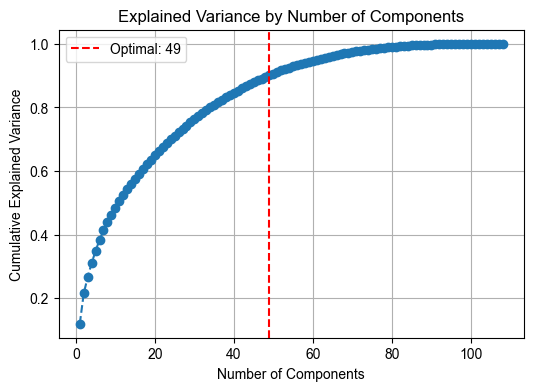

Optimal number of components: 49


In [261]:
def optimal_pca_components(data, explained_variance_threshold=0.9):
    """
    Performs PCA on the data and determines the optimal number of components
    based on the explained variance threshold.

    """
    # Step 1: Normalize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Step 2: PCA
    pca = PCA()
    pca_data = pca.fit_transform(data_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Select the optimal number of components based on the explained variance threshold
    optimal_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    reduced_data = pd.DataFrame(pca_data[:, :optimal_components],
                                columns=[f'PC{i+1}' for i in range(optimal_components)])

    # Plot cumulative explained variance
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Number of Components')
    plt.axvline(optimal_components, color='r', linestyle='--', label=f'Optimal: {optimal_components}')
    plt.legend()
    plt.grid()
    plt.show()

    return optimal_components, reduced_data

# Example usage:
optimal_components, reduced_data = optimal_pca_components(merged_df)
print("Optimal number of components:", optimal_components)

In [262]:
reduced_data.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
count,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,...,2.550000e+02,2.550000e+02,2.550000e+02,255.000000,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02
mean,-2.229154e-16,-5.572884e-17,1.114577e-16,5.572884e-17,-2.786442e-17,8.359326e-17,-1.114577e-16,1.393221e-17,-2.786442e-17,-1.567374e-17,...,-2.786442e-17,-2.786442e-17,-5.572884e-17,0.000000,-5.921189e-17,-1.567374e-17,-3.483053e-17,2.438137e-17,3.483053e-17,6.966105e-18
std,3.603997e+00,3.210939e+00,2.365004e+00,2.175232e+00,2.050525e+00,1.928116e+00,1.794846e+00,1.734109e+00,1.538732e+00,1.529125e+00,...,8.772095e-01,8.584384e-01,8.474921e-01,0.839018,8.310433e-01,8.219495e-01,8.100661e-01,7.884037e-01,7.798251e-01,7.564786e-01
min,-3.978946e+00,-6.678478e+00,-1.073358e+01,-3.601236e+00,-1.256004e+01,-7.235405e+00,-6.383771e+00,-1.522528e+01,-6.482241e+00,-5.358747e+00,...,-2.748563e+00,-2.636745e+00,-3.059600e+00,-3.293534,-2.559132e+00,-3.152118e+00,-2.897472e+00,-2.413214e+00,-1.944403e+00,-1.983342e+00
25%,-2.424162e+00,-2.933729e+00,-1.071797e+00,-1.481743e+00,-1.000342e+00,-1.114948e+00,-1.007985e+00,-6.508525e-01,-9.830444e-01,-8.509564e-01,...,-5.523489e-01,-5.630766e-01,-5.632636e-01,-0.533331,-4.927856e-01,-5.679818e-01,-5.542315e-01,-5.916942e-01,-4.857141e-01,-5.016117e-01
50%,-4.190830e-01,7.067791e-01,4.188447e-01,-6.973316e-01,-3.021988e-01,1.742898e-01,-1.248927e-01,-1.482224e-02,-1.112822e-01,-3.173231e-03,...,-5.197710e-02,-9.806498e-02,6.414421e-02,-0.022684,4.846465e-02,2.584363e-02,7.739520e-02,1.923658e-02,-4.494123e-02,-1.478004e-02
75%,1.090563e+00,2.468636e+00,1.549116e+00,1.168641e+00,9.567010e-01,1.096042e+00,1.323922e+00,6.776090e-01,1.121078e+00,6.018590e-01,...,6.194652e-01,5.730739e-01,5.389538e-01,0.505838,5.404641e-01,4.945732e-01,5.486243e-01,5.911536e-01,5.612649e-01,4.939111e-01
max,2.628056e+01,1.780865e+01,5.115483e+00,9.251106e+00,5.764461e+00,7.064841e+00,4.501791e+00,8.919408e+00,4.253974e+00,7.621693e+00,...,2.415891e+00,2.611685e+00,2.613025e+00,2.791580,2.221954e+00,2.249724e+00,1.985419e+00,2.199232e+00,2.565147e+00,2.390184e+00


________________

# Identifying the Optimal Number of Clusters



In this step, we determine the optimal number of clusters for our prediction task using two widely used methods:



*   Elbow Method: Evaluates the within-cluster sum of squares (WCSS) for different cluster counts to identify the point where the rate of decrease slows down (the "elbow"). This indicates a balance between minimizing variance within clusters and not overfitting the data.

*   Silhouette Score: Measures the quality of clustering by assessing how well each data point fits within its cluster compared to others. A higher silhouette score indicates better-defined clusters.





https://towardsdatascience.com/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c

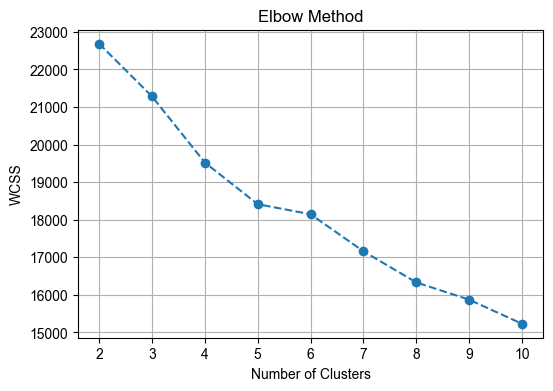

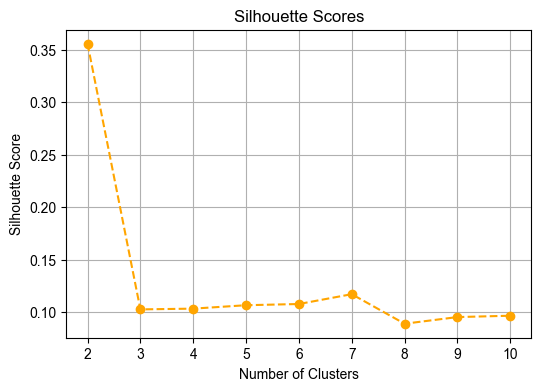

Optimal number of clusters based on Silhouette Score: 2


In [263]:
# Function to determine the optimal number of clusters using Elbow and Silhouette methods
def choose_optimal_clusters(data, max_clusters=10):
    """
    This function takes a DataFrame and evaluates the optimal number of clusters using
    the Elbow Method and Silhouette Score.
    """
    # Ensure data is in numerical format
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")

    # List to store within-cluster sum of squares (WCSS) and silhouette scores
    wcss = []
    silhouette_scores = []

    # Iterate through cluster counts from 2 to max_clusters
    for k in range(2, max_clusters + 1):
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)

        # Append WCSS to the list
        wcss.append(kmeans.inertia_)

        # Compute silhouette score and append to the list
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the Elbow Method
    plt.figure(figsize=(6, 4))
    plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.show()

    # Plot the Silhouette Scores
    plt.figure(figsize=(6, 4))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--', color='orange')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # Print the optimal number of clusters based on the silhouette score
    optimal_clusters = np.argmax(silhouette_scores) + 2  # Add 2 because range starts from 2
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_clusters}")

# Example usage with a sample DataFrame
choose_optimal_clusters(reduced_data)

Evaluating Model Performance at Each Stage


In [264]:
# Function to compute KMeans clustering and silhouette score for a given DataFrame
def compute_silhouette(data, n_clusters=2, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(data)
    silhouette = silhouette_score(data, labels)
    return silhouette

# DataFrames to compare
dataframes = {
    "Reduced DataFrame": reduced_data,
    "Merged DataFrame": merged_df,
    "Original DataFrame": df_1
}

# Compare silhouette scores for each DataFrame
results = {}
for name, dataframe in dataframes.items():
    try:
        # Calculate silhouette score for each DataFrame
        silhouette = compute_silhouette(dataframe)
        results[name] = silhouette
    except Exception as e:
        results[name] = f"Error: {e}"

# Print the results
for name, score in results.items():
    print(f"Silhouette Score for {name}: {score}")


Silhouette Score for Reduced DataFrame: 0.3557846029521605
Silhouette Score for Merged DataFrame: 0.20617984622299773
Silhouette Score for Original DataFrame: 0.5092838290407949


Processing: Reduced DataFrame
Processing: Merged DataFrame
Processing: Original DataFrame


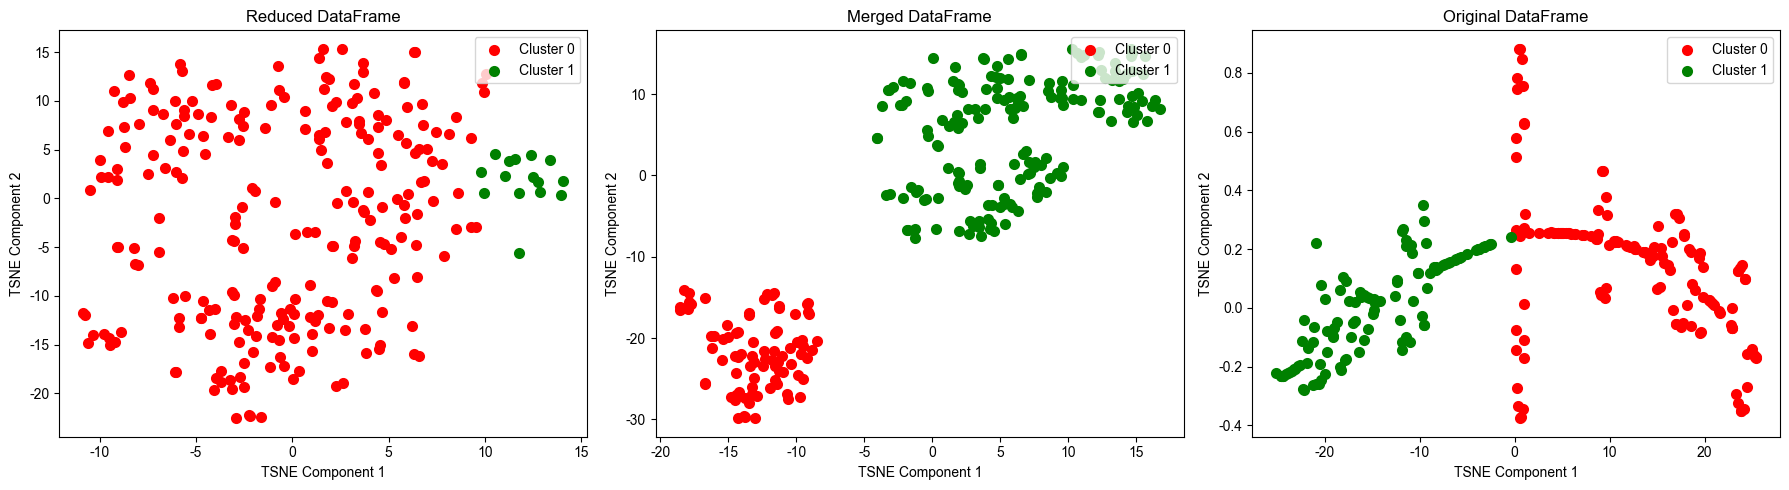

In [265]:
def visualize_clustering_with_tsne_side_by_side(dataframes, n_clusters=2, random_state=42):
    """
    Apply TSNE and KMeans clustering on multiple DataFrames and visualize the clustering results side by side.
    """
    # Define colors for up to 10 clusters
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow',
              'cyan', 'magenta', 'brown', 'pink']

    # Create a figure with subplots (one for each DataFrame)
    fig, axes = plt.subplots(1, len(dataframes), figsize=(6 * len(dataframes), 5))

    # If there's only one DataFrame, make axes iterable
    if len(dataframes) == 1:
        axes = [axes]

    for ax, (name, dataframe) in zip(axes, dataframes.items()):
        print(f"Processing: {name}")

        # Apply TSNE on the current DataFrame
        tsne = TSNE(n_components=2, random_state=random_state)
        X_tsne = tsne.fit_transform(dataframe)

        # Apply KMeans to get cluster labels
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = kmeans.fit_predict(dataframe)

        # Visualize clustering
        for i, color in enumerate(colors[:len(np.unique(labels))]):
            ax.scatter(X_tsne[labels == i, 0], X_tsne[labels == i, 1],
                       color=color, lw=2, label=f'Cluster {i}')

        ax.set_title(f'{name}')
        ax.set_xlabel('TSNE Component 1')
        ax.set_ylabel('TSNE Component 2')
        ax.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

visualize_clustering_with_tsne_side_by_side(dataframes, n_clusters=2)

# Exploring Dimensionality Reduction with Kernel PCA


https://github.com/raghuram-venugopal/Unsupervised_Model/blob/main/PCA/Kernal_PCA.ipynb


To address the possibility of non-linear relationships in the data, we applied Kernel PCA for dimensionality reduction. Unlike standard PCA, Kernel PCA maps the data to a higher-dimensional space using kernel functions, enabling it to capture non-linear patterns.

This approach was motivated by the suspicion that the consolidated dataset contains non-linear relationships that were not effectively captured by standard PCA.

We tested two types of kernel functions and compared their performance:

*   RBF (Radial Basis Function): Suitable for data distributed in circular or complex geometric structures.
*   Sigmoid Kernel: Often used when the data exhibits S-shaped relationships.


---

The gamma parameter for each kernel was carefully selected





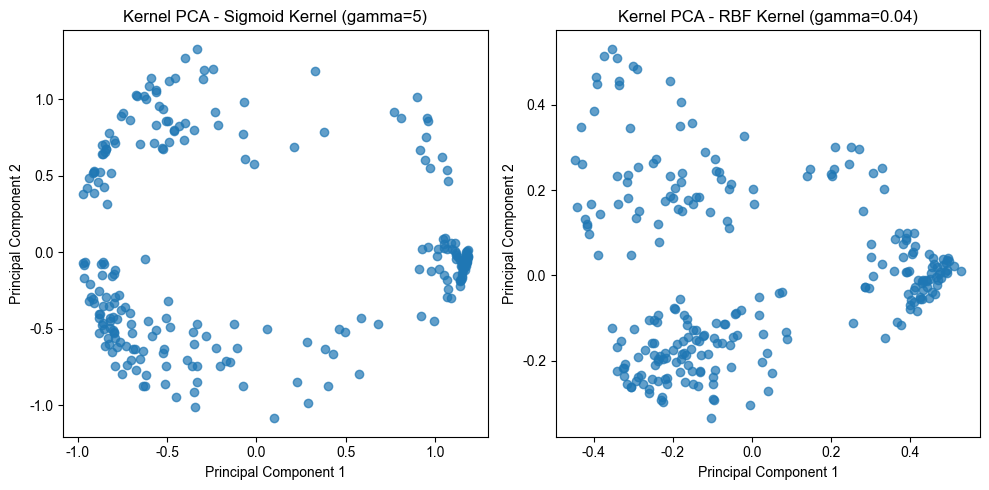

In [266]:
kpcas = KernelPCA(n_components=3, kernel='sigmoid', gamma=5)
kpcar = KernelPCA(n_components=3, kernel='rbf', gamma=0.04)

X_sigmoid = kpcas.fit_transform(merged_df)
X_rbf = kpcar.fit_transform(merged_df)

# Plotting the results side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot for Kernel PCA with sigmoid kernel
axes[0].scatter(X_sigmoid[:, 0], X_sigmoid[:, 1], alpha=0.7)
axes[0].set_title('Kernel PCA - Sigmoid Kernel (gamma=5)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot for Kernel PCA with rbf kernel
axes[1].scatter(X_rbf[:, 0], X_rbf[:, 1], alpha=0.7)
axes[1].set_title('Kernel PCA - RBF Kernel (gamma=0.04)')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

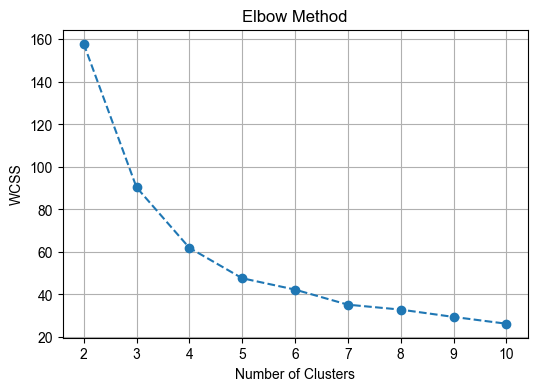

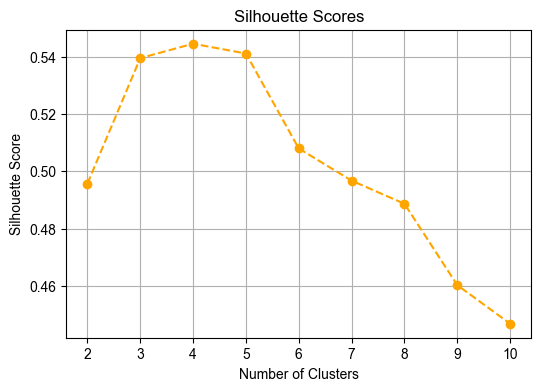

Optimal number of clusters based on Silhouette Score: 4


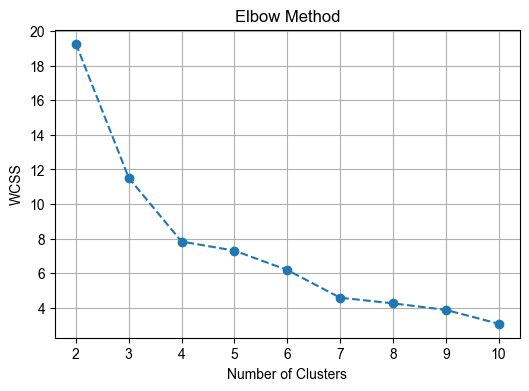

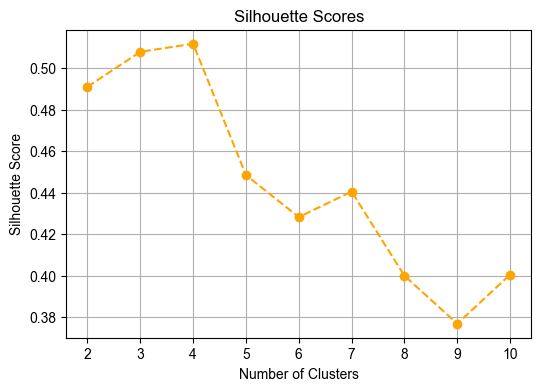

Optimal number of clusters based on Silhouette Score: 4


In [267]:
# Convert the results into DataFrames
df_sigmoid = pd.DataFrame(X_sigmoid, columns=['PC1_sigmoid', 'PC2_sigmoid', 'PC3_sigmoid'])
df_rbf = pd.DataFrame(X_rbf, columns=['PC1_rbf', 'PC2_rbf', 'PC3_rbf'])
choose_optimal_clusters(df_sigmoid)
choose_optimal_clusters(df_rbf)


To evaluate the performance of these methods, we used the following metrics:


*   Silhouette Score: Assesses the quality of clustering based on the separation and cohesion of clusters.
*   Davies-Bouldin Index: Measures the average similarity ratio of clusters; lower values indicate better clustering.
*   Calinski-Harabasz Index: Evaluates the ratio of the sum of between-cluster dispersion to within-cluster dispersion; higher values indicate better-defined clusters.
*   Inertia: Measures the sum of squared distances between data points and their respective cluster centroids; lower values indicate tighter clustering.





In [268]:
# Perform KMeans clustering
kmeans_rbf = KMeans(n_clusters=3, random_state=42).fit(X_rbf)
kmeans_sigmoid = KMeans(n_clusters=4, random_state=42).fit(X_sigmoid)

clusters_rbf = kmeans_rbf.predict(X_rbf)
clusters_sigmoid = kmeans_sigmoid.predict(X_sigmoid)

# Evaluate clustering
def evaluate_clustering(metric, X_rbf, X_sigmoid, clusters_rbf, clusters_sigmoid):
    results = {}

    if metric == "silhouette":
        results["RBF"] = silhouette_score(X_rbf, clusters_rbf)
        results["Sigmoid"] = silhouette_score(X_sigmoid, clusters_sigmoid)
    elif metric == "davies_bouldin":
        results["RBF"] = davies_bouldin_score(X_rbf, clusters_rbf)
        results["Sigmoid"] = davies_bouldin_score(X_sigmoid, clusters_sigmoid)
    elif metric == "calinski_harabasz":
        results["RBF"] = calinski_harabasz_score(X_rbf, clusters_rbf)
        results["Sigmoid"] = calinski_harabasz_score(X_sigmoid, clusters_sigmoid)
    elif metric == "inertia":
        results["RBF"] = kmeans_rbf.inertia_
        results["Sigmoid"] = kmeans_sigmoid.inertia_
    else:
        raise ValueError("Metric not recognized.")

    return results

# Create comparison table
def create_comparison_table(X_rbf, X_sigmoid, clusters_rbf, clusters_sigmoid):
    metrics = ["silhouette", "davies_bouldin", "calinski_harabasz", "inertia"]
    comparison_results = {}

    for metric in metrics:
        results = evaluate_clustering(metric, X_rbf, X_sigmoid, clusters_rbf, clusters_sigmoid)
        comparison_results[metric] = results

    df_comparison = pd.DataFrame(comparison_results).T
    df_comparison.columns = ["RBF", "Sigmoid"]

    return df_comparison

# Generate comparison table
comparison_table = create_comparison_table(X_rbf, X_sigmoid, clusters_rbf, clusters_sigmoid)
comparison_table

,RBF,Sigmoid
silhouette,0.507956,0.544456
davies_bouldin,0.867914,0.686383
calinski_harabasz,303.318595,348.342122
inertia,11.510524,61.939908


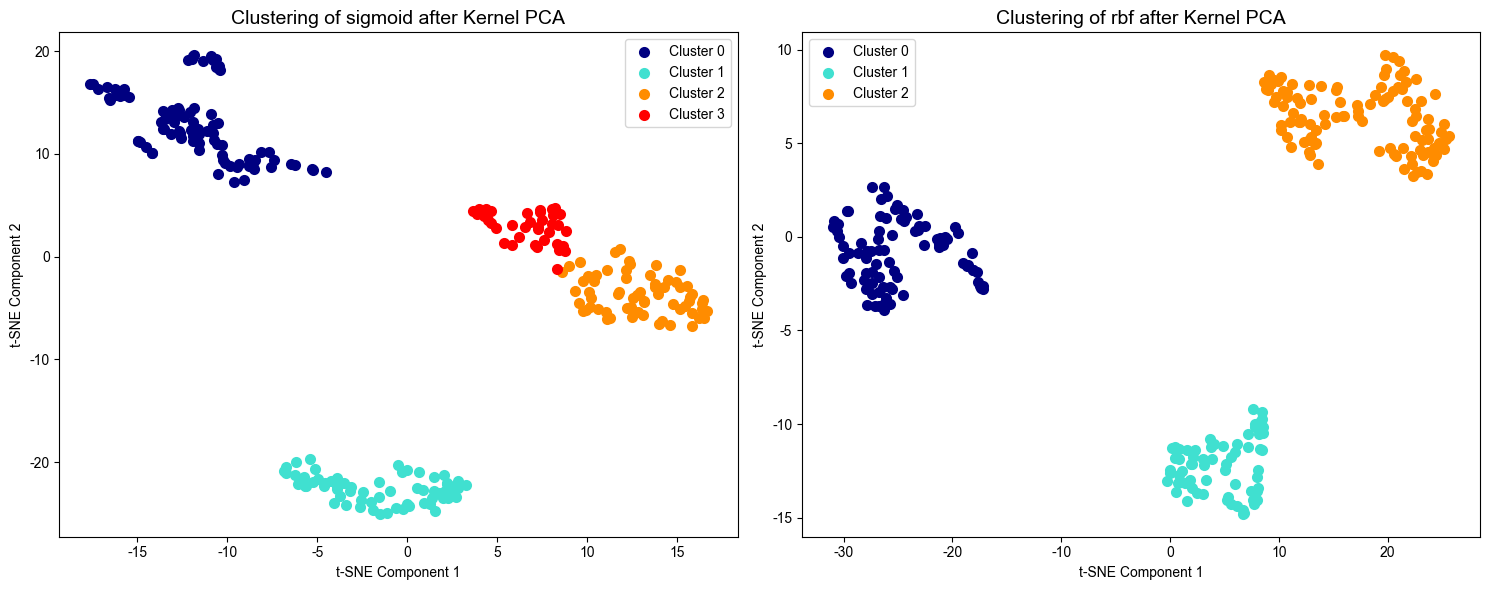

In [269]:
# Adjusted number of clusters for each dataset
k_sigmoid = 4
k_rbf = 3

# List of colors for visualizing clusters
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Define the datasets to be used
datasets = {
    'sigmoid': (X_sigmoid, k_sigmoid),
    'rbf': (X_rbf, k_rbf)
}

# Loop through the datasets and create a plot for each
for ax, (name, (data, k)) in zip(axes, datasets.items()):
    # Initialize KMeans model with the specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit the KMeans model and predict cluster labels
    clusters = kmeans.fit_predict(data)

    # Apply t-SNE transformation to the data
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(data)

    # Iterate over each cluster and plot its points with a unique color
    for i, color in zip(range(k), colors):
        # Mask for the current cluster
        cluster_mask = (clusters == i)

        # Scatter plot for the cluster
        ax.scatter(
            X_tsne[cluster_mask, 0],  # x-coordinates of points in cluster i
            X_tsne[cluster_mask, 1],  # y-coordinates of points in cluster i
            color=color,  # Assign a unique color to this cluster
            lw=2,  # Line width for scatter points
            label=f'Cluster {i}'  # Label for legend
        )

    # Set title for each plot
    ax.set_title(f'Clustering of {name} after Kernel PCA', fontsize=14)

    # Set axis labels
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')

    # Add legend to the plot
    ax.legend(loc='best')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

_____________

#Hierarchical Clustering

As part of our exploration, we also experimented with Hierarchical Clustering to evaluate its potential for identifying meaningful clusters in the dataset.

Hierarchical Clustering was chosen because it does not require predefining the number of clusters and provides a dendrogram that offers insights into the relationships and hierarchy between data points. This method is particularly useful when the data might have nested or hierarchical structures.


---
We wanted to examine the data without creating a bias and in addition to minimize the variation therefore we used Wards Linkage


In [270]:
# Perform hierarchical clustering using the Ward method on the PCA-reduced data
Z_pca_df = linkage(reduced_data, 'ward')

# Fit the Agglomerative Clustering model with 3 clusters to the linkage matrix
clustering_Agg = AgglomerativeClustering(n_clusters=3).fit(Z_pca_df)

# Extract the cluster labels assigned to each data point
hier_labels = clustering_Agg.labels_

# Calculate clustering evaluation metrics to assess the quality of the clustering
# Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters (higher is better)
score_sil = silhouette_score(Z_pca_df, hier_labels, metric='euclidean')

# Davies-Bouldin Index: Measures the average similarity ratio of clusters (lower is better)
score_db = davies_bouldin_score(Z_pca_df, hier_labels)

# Calinski-Harabasz Index: Measures the ratio of within-cluster dispersion to between-cluster dispersion (higher is better)
score_ch = calinski_harabasz_score(Z_pca_df, hier_labels)

# Print the clustering evaluation metrics
print('Calinski-Harabasz Index: %.3f' % score_ch)
print('Davies-Bouldin Index: %.3f' % score_db)
print('Silhouett Score: %.3f' % score_sil)


Calinski-Harabasz Index: 413.254
Davies-Bouldin Index: 0.751
Silhouett Score: 0.466


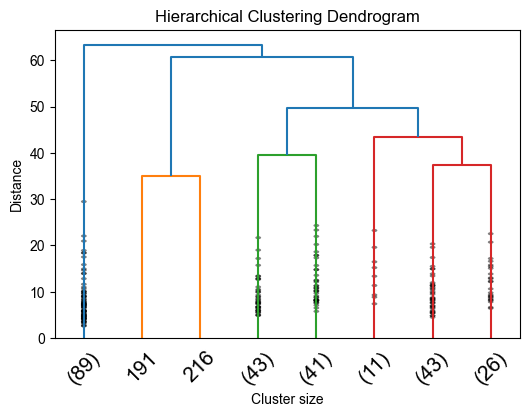

In [271]:
plt.figure(figsize=(6, 4))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z_pca_df, truncate_mode='lastp',p=8, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

<Axes: title={'center': 'Hierarchical Clustering TSNE'}, xlabel='feature1', ylabel='feature2'>

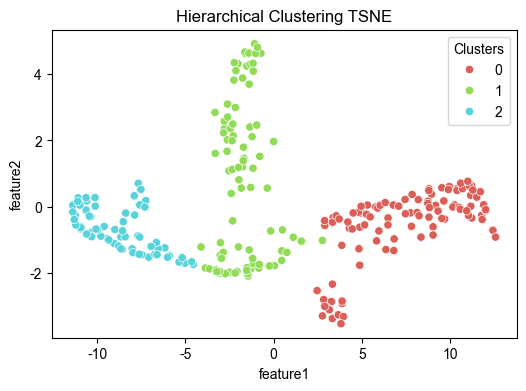

In [272]:
tsne = TSNE(n_components=2,
            perplexity=50,
            random_state=42,
            n_iter=300).fit_transform(Z_pca_df)

df_embed_hier = pd.DataFrame(tsne, columns=['feature1', 'feature2'])
df_embed_hier['Clusters']= pd.DataFrame(hier_labels)
plt.figure(figsize=(6,4))
plt.title('Hierarchical Clustering TSNE')

sns.scatterplot(
    x='feature1', y='feature2',
    data=df_embed_hier,
    hue=df_embed_hier['Clusters'],
    palette=sns.color_palette("hls", 4)
)

_______________

#Final Choice: RBF Kernel PCA with 3 Clusters


Summary:
After thoroughly evaluating various dimensionality reduction and clustering methods, we selected RBF Kernel PCA with a division into 3 clusters as the final approach.

This decision was based on a combination of visual inspection and performance metrics, where the RBF kernel consistently achieved the highest scores across all evaluation methods, including:

Silhouette Score, Davies-Bouldin Index,Calinski-Harabasz Index, Inertia
The RBF Kernel PCA outperformed the following alternatives:

PCA with clustering into 2 groups,
Kernel PCA with a sigmoid kernel,
Hierarchical clustering
The superior performance of RBF Kernel PCA, both in terms of quantitative metrics and qualitative visual analysis, made it the most suitable choice for this dataset. This method ensures a well-defined clustering structure and captures the non-linear relationships in the data effectively.

In [273]:
X_rbf = X_rbf[:len(merged_df)]

# Fit the KMeans model and predict cluster labels for the rbf dataset
clusters_rbf = kmeans.fit_predict(X_rbf)

# Add the cluster labels to the DataFrame
df['cluster_labels_rbf'] = clusters_rbf

df['cluster_labels_rbf'] = df['cluster_labels_rbf'].astype('category')

In [274]:
# Define a mapping for 'Settlement Religion' values
religion_mapping = {
    1: "יהודי",  # Jewish
    2: "ערבי",   # Arab
    3: "בדואי",  # Bedouin
    4: "מעורב"   # Mixed
}

# Replace the numeric values in the 'Settlement Religion' column with the mapped text
df['Settlement Religion'] = df['Settlement Religion'].replace(religion_mapping)

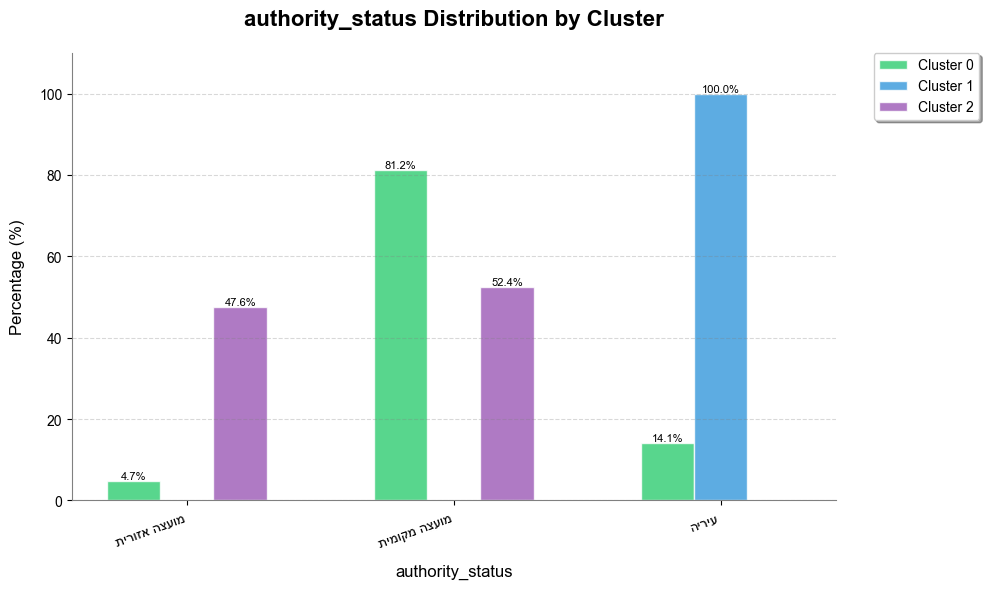


Percentage values for authority_status:
                  0      1      2
מועצה אזורית   4.71    0.0  47.62
מועצה מקומית  81.18    0.0  52.38
עיריה         14.12  100.0   0.00


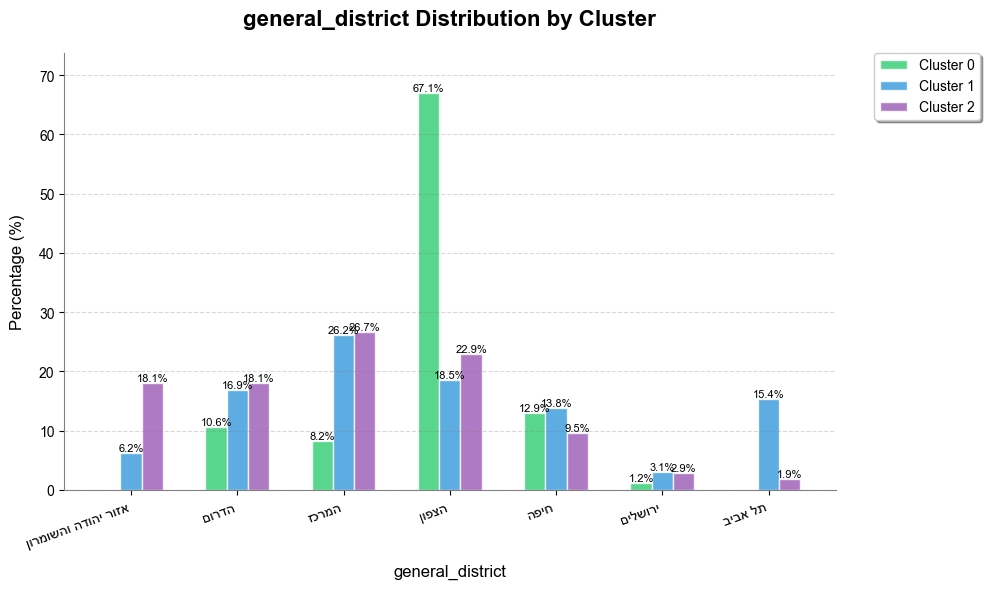


Percentage values for general_district:
                         0      1      2
אזור יהודה והשומרון   0.00   6.15  18.10
הדרום                10.59  16.92  18.10
המרכז                 8.24  26.15  26.67
הצפון                67.06  18.46  22.86
חיפה                 12.94  13.85   9.52
ירושלים               1.18   3.08   2.86
תל אביב               0.00  15.38   1.90


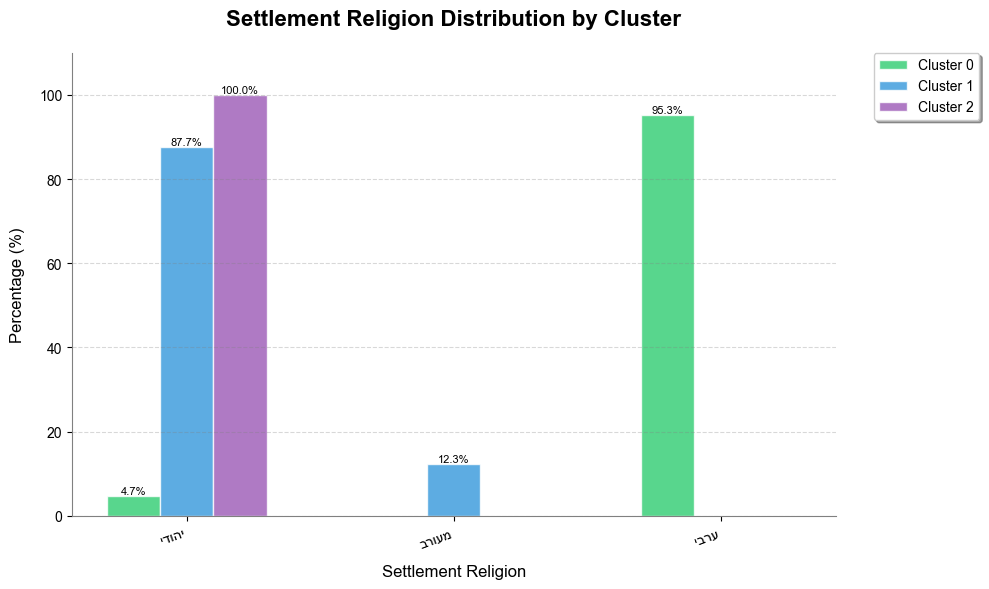


Percentage values for Settlement Religion:
           0      1      2
יהודי   4.71  87.69  100.0
מעורב   0.00  12.31    0.0
ערבי   95.29   0.00    0.0


In [275]:
def reshape_hebrew(text):
    text = str(text)
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

def analyze_categorical(df_1, cluster_col, cat_cols, frequency_threshold=0):
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#f1c40f', '#e74c3c']

    clusters = sorted(df_1[cluster_col].unique())

    for cat_col in cat_cols:
        # Create figure with white background
        fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
        ax.set_facecolor('white')

        # Calculate distribution for each cluster
        cluster_percentages = {}
        all_categories = set()

        for cluster in clusters:
            cluster_df = df_1[df_1[cluster_col] == cluster]
            cluster_freq = cluster_df[cat_col].value_counts()
            cluster_freq_percent = (cluster_freq / len(cluster_df)) * 100
            cluster_percentages[cluster] = cluster_freq_percent
            all_categories.update(cluster_freq_percent.index)

        all_categories = sorted(list(all_categories))
        plot_data = pd.DataFrame(index=all_categories, columns=clusters)

        for cluster in clusters:
            plot_data[cluster] = cluster_percentages[cluster]

        plot_data = plot_data.fillna(0)

        # Bar positions and settings
        x = np.arange(len(plot_data.index))
        width = 0.2

        # Create bars with enhanced style
        for i, cluster in enumerate(clusters):
            bars = ax.bar(x + i*width,
                         plot_data[cluster],
                         width,
                         label=f'Cluster {cluster}',
                         color=colors[i],
                         alpha=0.8,
                         edgecolor='white',
                         linewidth=1)

            # Add value labels on top of bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}%',
                           ha='center', va='bottom',
                           fontsize=8)

        # Customize plot
        hebrew_labels = [reshape_hebrew(label) for label in plot_data.index]
        ax.set_xticks(x + width)
        ax.set_xticklabels(hebrew_labels, rotation=20, ha='right')

        # Title and labels
        ax.set_title(reshape_hebrew(f'{cat_col} Distribution by Cluster'),
                    fontsize=16, pad=20, fontweight='bold')
        ax.set_xlabel(reshape_hebrew(cat_col), fontsize=12, labelpad=10)
        ax.set_ylabel(reshape_hebrew('Percentage (%)'), fontsize=12, labelpad=10)

        # Legend
        ax.legend(bbox_to_anchor=(1.05, 1),
                 loc='upper left',
                 borderaxespad=0.,
                 frameon=True,
                 fancybox=True,
                 shadow=True)

        # Grid
        ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')

        # Spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('gray')
        ax.spines['bottom'].set_color('gray')

        # Y-axis limits
        ax.set_ylim(0, plot_data.max().max() * 1.1)

        plt.tight_layout()
        plt.show()

        # Print numerical values
        print(f"\nPercentage values for {cat_col}:")
        print(plot_data.round(2).to_string())

analyze_categorical(df, 'cluster_labels_rbf', columns_to_encode)

In [276]:
# Function to validate numerical columns
def validate_numeric_columns(df, num_cols):
    # Identify non-numeric columns
    non_numeric_cols = [col for col in num_cols if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col])]
    if non_numeric_cols:
        print(f"The following columns are not numeric or do not exist in the DataFrame: {', '.join(non_numeric_cols)}")
    # Return only valid numeric columns
    return [col for col in num_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

# List of columns to check
numerical_columns = [
     'budget_total_income',
     'arnona_area_total', 'land_total_area_km2',
    'general_municipal_status_year', 'demo_total_pop',
   'welfare_disability_work_count',
    'welfare_children_receiving_allowances_total',
    'edu_students_highschool', 'general_dist_tel_aviv_km', 'transport_accidents_total',
    'demo_migration_balance_total'
]

# Validate and filter numerical columns
validated_num_cols = validate_numeric_columns(df, numerical_columns)

In [277]:
def analyze_numerical_by_cluster(df, cluster_col, num_cols):
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#f1c40f', '#e74c3c']
    clusters = sorted(df[cluster_col].unique())

    for num_col in num_cols:
        # Skip non-numerical columns
        if not pd.api.types.is_numeric_dtype(df[num_col]):
            print(f"Skipping {num_col} - not numeric")
            continue

        # Create the bar chart
        fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
        summary_data = df.groupby(cluster_col)[num_col].agg(['mean', 'std']).fillna(0)

        x = np.arange(len(clusters))
        width = 0.5

        bars = ax.bar(x, summary_data['mean'], width,
                      yerr=summary_data['std'],
                      capsize=5,
                      color=colors[:len(clusters)],
                      alpha=0.8,
                      edgecolor='gray',
                      linewidth=1.5)

        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height + (0.02 * height),
                    f'{height:.1f}\n±{summary_data["std"][i]:.1f}',
                    ha='center', va='bottom', fontsize=10, color='black')

        ax.set_title(f'{num_col} by Cluster', fontsize=16, pad=15)
        ax.set_xlabel('Cluster', fontsize=12)
        ax.set_ylabel(num_col, fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([f'Cluster {c}' for c in clusters], fontsize=11)
        ax.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Print formatted table using tabulate
        table = df.groupby(cluster_col)[num_col].describe().round(2)
        print(f"\nStatistics for {num_col}:")
        print(tabulate(table, headers='keys', tablefmt='grid'))  # Change 'grid' to 'pretty' or 'pipe' for other styles


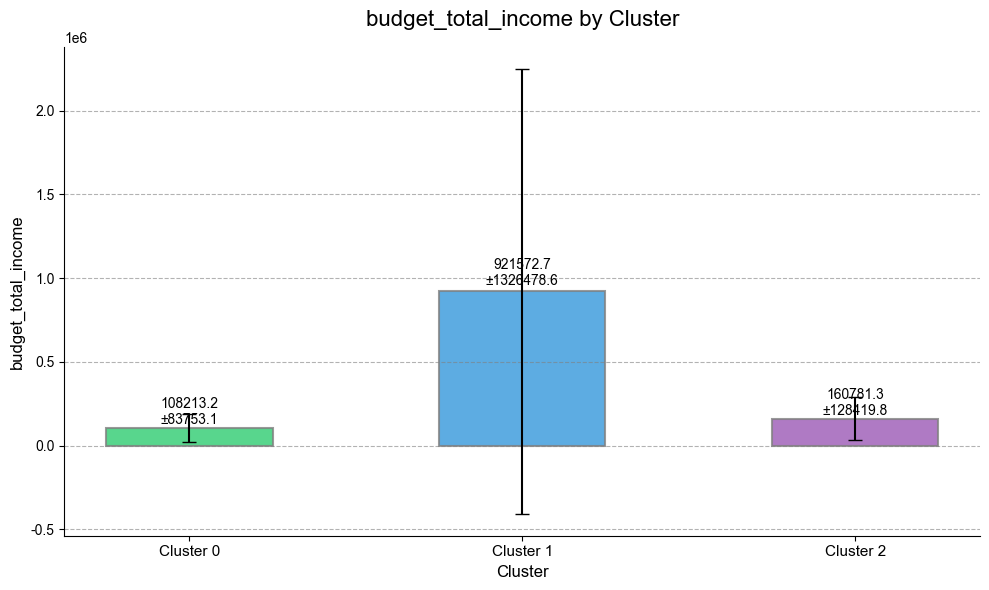


Statistics for budget_total_income:
+----------------------+---------+--------+------------------+--------+--------+--------+--------+------------------+
|   cluster_labels_rbf |   count |   mean |              std |    min |    25% |    50% |    75% |              max |
+======================+=========+========+==================+========+========+========+========+==================+
|                    0 |      85 | 108213 |  83753.1         |  21284 |  56761 |  88314 | 120781 | 453326           |
+----------------------+---------+--------+------------------+--------+--------+--------+--------+------------------+
|                    1 |      65 | 921573 |      1.32648e+06 | 152984 | 333602 | 497601 | 923180 |      7.87445e+06 |
+----------------------+---------+--------+------------------+--------+--------+--------+--------+------------------+
|                    2 |     105 | 160781 | 128420           |  19888 |  70866 | 134667 | 214322 | 817376           |
+------------------

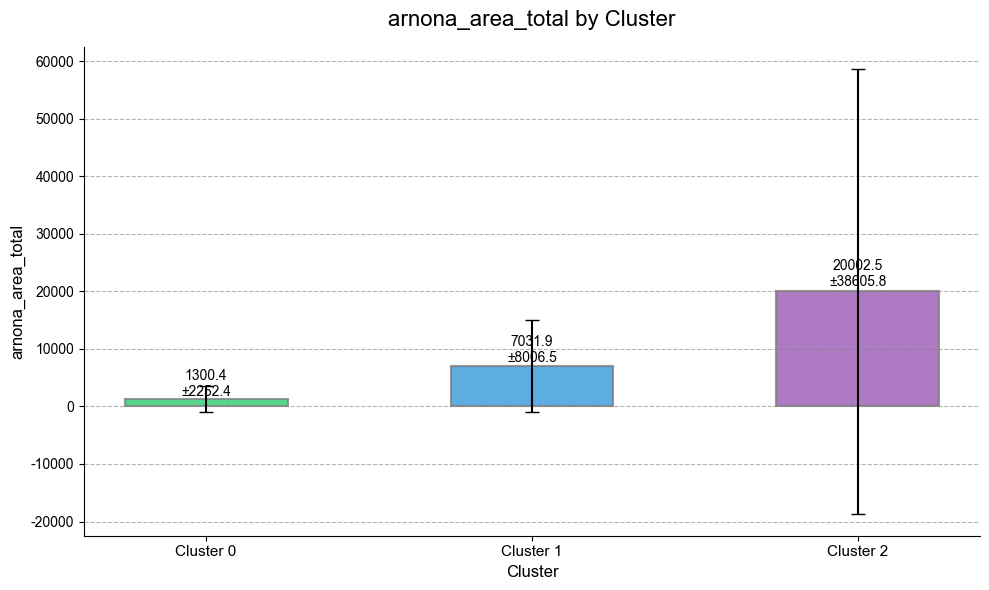


Statistics for arnona_area_total:
+----------------------+---------+---------+----------+-------+--------+--------+---------+----------+
|   cluster_labels_rbf |   count |    mean |      std |   min |    25% |    50% |     75% |      max |
+======================+=========+=========+==========+=======+========+========+=========+==========+
|                    0 |      85 |  1300.4 |  2252.43 |   0   |  256.6 |  464.8 |   956.5 |  12550.6 |
+----------------------+---------+---------+----------+-------+--------+--------+---------+----------+
|                    1 |      65 |  7031.9 |  8006.52 | 943.4 | 1888.2 | 3485.5 |  8795.9 |  33626.8 |
+----------------------+---------+---------+----------+-------+--------+--------+---------+----------+
|                    2 |     105 | 20002.5 | 38605.8  |  85.9 |  595.6 | 2815.8 | 17647.5 | 181016   |
+----------------------+---------+---------+----------+-------+--------+--------+---------+----------+


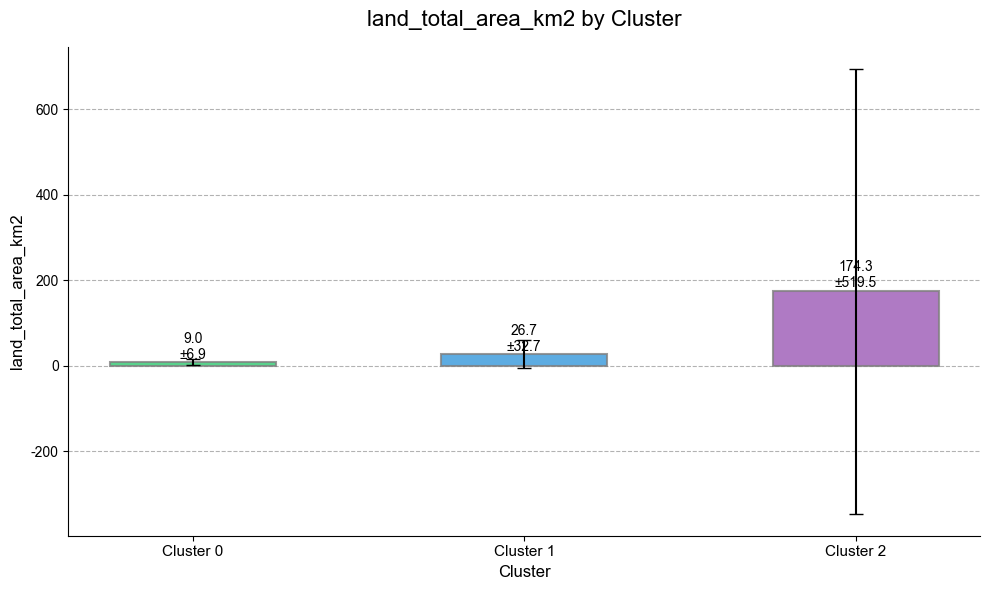


Statistics for land_total_area_km2:
+----------------------+---------+--------+--------+-------+-------+-------+--------+---------+
|   cluster_labels_rbf |   count |   mean |    std |   min |   25% |   50% |    75% |     max |
+======================+=========+========+========+=======+=======+=======+========+=========+
|                    0 |      85 |   9.03 |   6.92 |  0.98 |  4.31 |  7.15 |  11.03 |   38.6  |
+----------------------+---------+--------+--------+-------+-------+-------+--------+---------+
|                    1 |      65 |  26.73 |  32.72 |  2.55 |  8.16 | 14.82 |  29.98 |  173.01 |
+----------------------+---------+--------+--------+-------+-------+-------+--------+---------+
|                    2 |     105 | 174.28 | 519.49 |  0.5  |  5.91 | 13.71 | 127.94 | 4099.24 |
+----------------------+---------+--------+--------+-------+-------+-------+--------+---------+


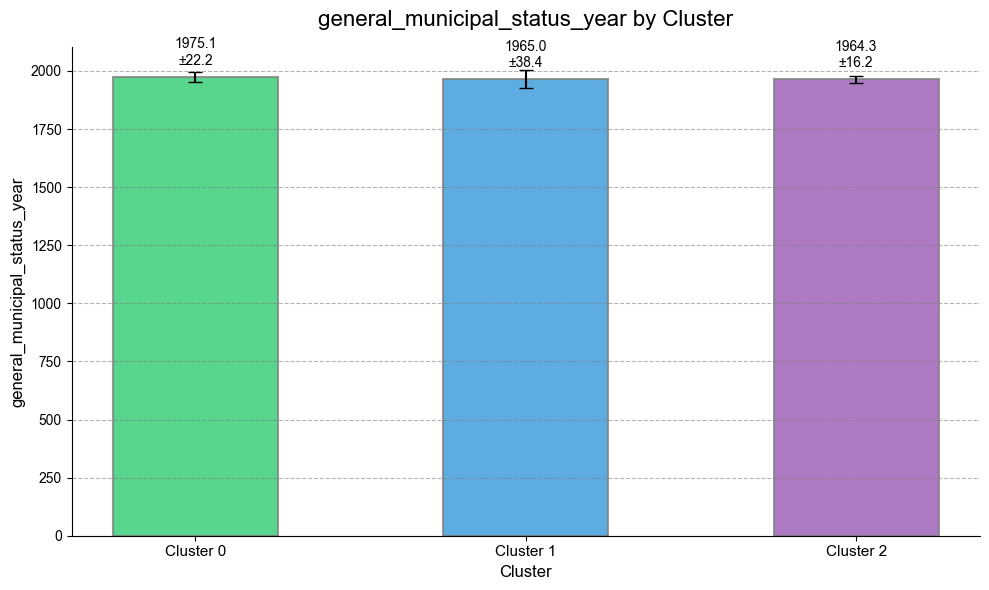


Statistics for general_municipal_status_year:
+----------------------+---------+---------+-------+-------+-------+-------+-------+-------+
|   cluster_labels_rbf |   count |    mean |   std |   min |   25% |   50% |   75% |   max |
+======================+=========+=========+=======+=======+=======+=======+=======+=======+
|                    0 |      85 | 1975.06 | 22.24 |  1877 |  1964 |  1975 |  1991 |  2016 |
+----------------------+---------+---------+-------+-------+-------+-------+-------+-------+
|                    1 |      65 | 1964.95 | 38.42 |  1877 |  1950 |  1974 |  1995 |  2007 |
+----------------------+---------+---------+-------+-------+-------+-------+-------+-------+
|                    2 |     105 | 1964.32 | 16.16 |  1940 |  1950 |  1956 |  1980 |  1997 |
+----------------------+---------+---------+-------+-------+-------+-------+-------+-------+


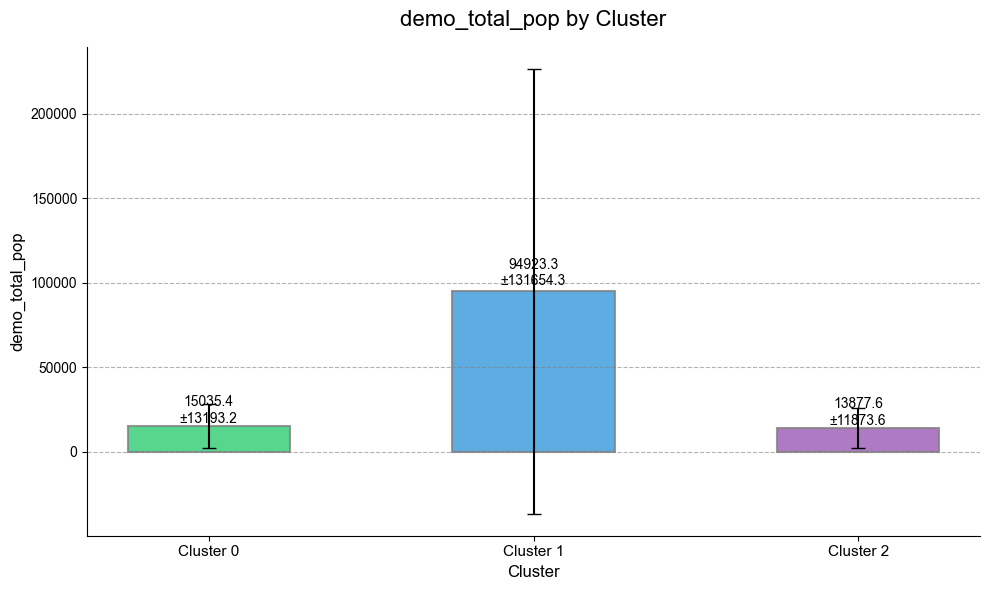


Statistics for demo_total_pop:
+----------------------+---------+---------+----------+-------+-------+-------+-------+--------+
|   cluster_labels_rbf |   count |    mean |      std |   min |   25% |   50% |   75% |    max |
+======================+=========+=========+==========+=======+=======+=======+=======+========+
|                    0 |      85 | 15035.4 |  13193.2 |  2063 |  6941 | 11799 | 18890 |  77063 |
+----------------------+---------+---------+----------+-------+-------+-------+-------+--------+
|                    1 |      65 | 94923.3 | 131654   | 18226 | 34135 | 50213 | 95683 | 919438 |
+----------------------+---------+---------+----------+-------+-------+-------+-------+--------+
|                    2 |     105 | 13877.6 |  11873.6 |  1241 |  6042 | 10088 | 18121 |  67111 |
+----------------------+---------+---------+----------+-------+-------+-------+-------+--------+


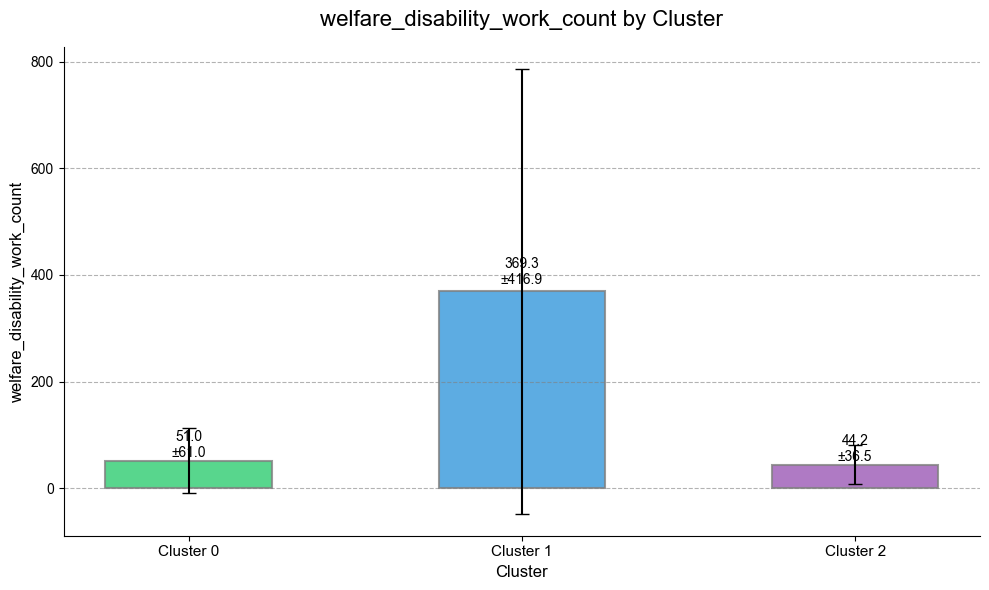


Statistics for welfare_disability_work_count:
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+
|   cluster_labels_rbf |   count |   mean |    std |   min |   25% |   50% |   75% |   max |
+======================+=========+========+========+=======+=======+=======+=======+=======+
|                    0 |      85 |  51.02 |  61.03 |     0 |    19 |    31 |    67 |   477 |
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+
|                    1 |      65 | 369.28 | 416.87 |     6 |   120 |   209 |   395 |  2052 |
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+
|                    2 |     105 |  44.23 |  36.52 |     0 |    14 |    39 |    58 |   161 |
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+


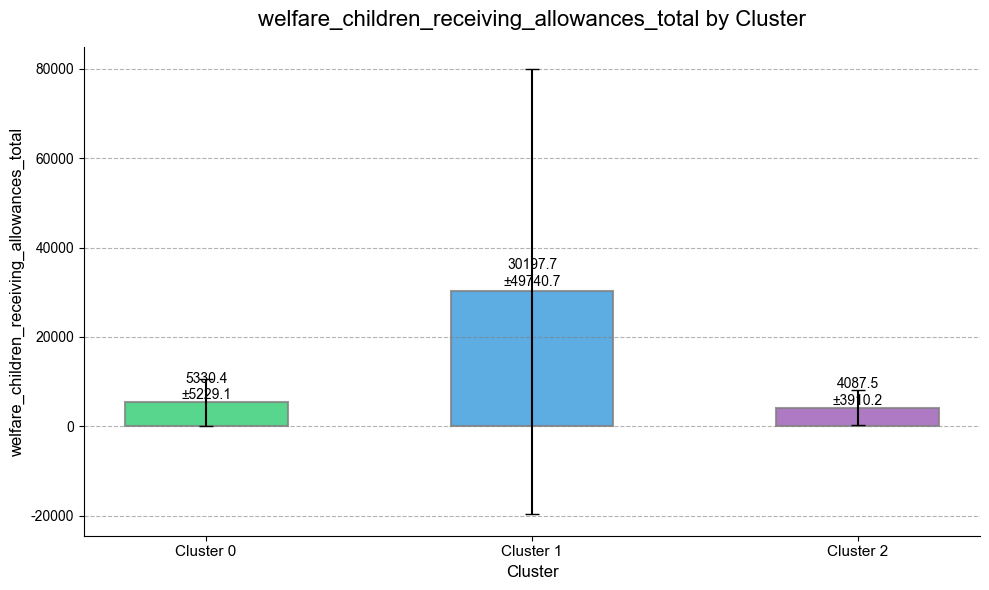


Statistics for welfare_children_receiving_allowances_total:
+----------------------+---------+----------+---------+-------+-------+-------+-------+--------+
|   cluster_labels_rbf |   count |     mean |     std |   min |   25% |   50% |   75% |    max |
+======================+=========+==========+=========+=======+=======+=======+=======+========+
|                    0 |      85 |  5330.44 |  5229.1 |   745 |  2166 |  3689 |  6576 |  32239 |
+----------------------+---------+----------+---------+-------+-------+-------+-------+--------+
|                    1 |      65 | 30197.7  | 49740.7 |  4663 |  9756 | 14389 | 32827 | 378654 |
+----------------------+---------+----------+---------+-------+-------+-------+-------+--------+
|                    2 |     105 |  4087.5  |  3910.2 |   305 |  1831 |  3333 |  4943 |  29861 |
+----------------------+---------+----------+---------+-------+-------+-------+-------+--------+


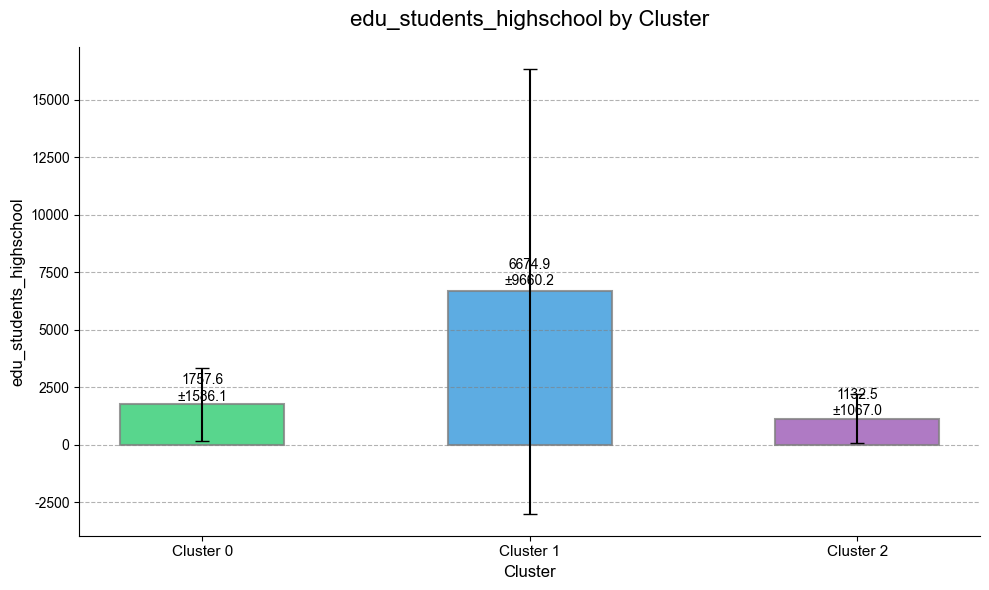


Statistics for edu_students_highschool:
+----------------------+---------+---------+---------+-------+-------+-------+-------+-------+
|   cluster_labels_rbf |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
+======================+=========+=========+=========+=======+=======+=======+=======+=======+
|                    0 |      85 | 1757.62 | 1586.06 |     0 |   720 |  1250 |  2358 |  8783 |
+----------------------+---------+---------+---------+-------+-------+-------+-------+-------+
|                    1 |      65 | 6674.86 | 9660.25 |   927 |  2136 |  3693 |  6995 | 71578 |
+----------------------+---------+---------+---------+-------+-------+-------+-------+-------+
|                    2 |     105 | 1132.54 | 1067    |     0 |   222 |   933 |  1615 |  5050 |
+----------------------+---------+---------+---------+-------+-------+-------+-------+-------+


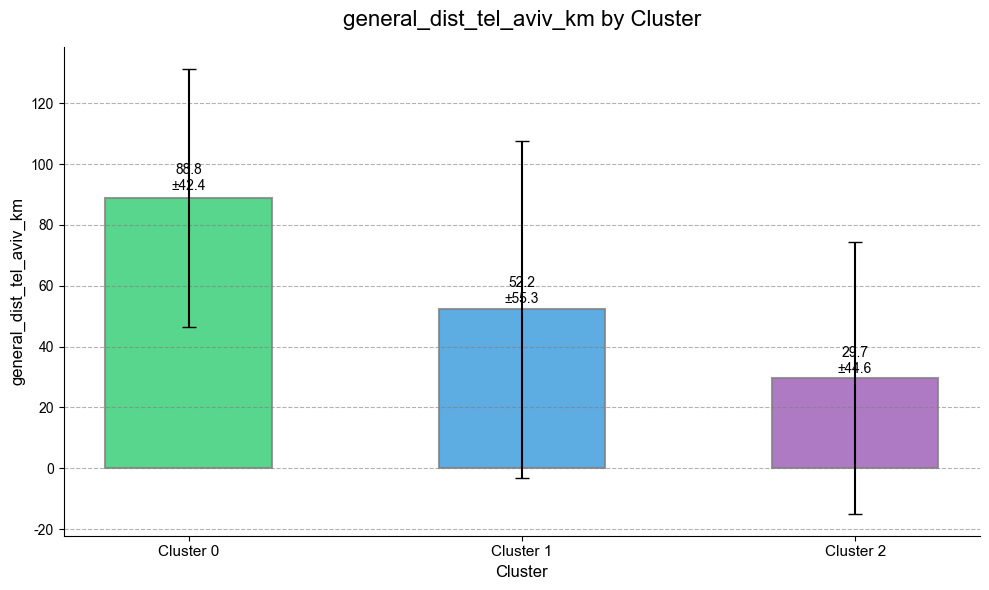


Statistics for general_dist_tel_aviv_km:
+----------------------+---------+--------+-------+-------+-------+-------+-------+-------+
|   cluster_labels_rbf |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
+======================+=========+========+=======+=======+=======+=======+=======+=======+
|                    0 |      85 |  88.78 | 42.4  |     0 |  71.9 |  94   | 111.6 | 183.2 |
+----------------------+---------+--------+-------+-------+-------+-------+-------+-------+
|                    1 |      65 |  52.22 | 55.28 |     0 |   6.8 |  39.5 |  86.1 | 321.4 |
+----------------------+---------+--------+-------+-------+-------+-------+-------+-------+
|                    2 |     105 |  29.75 | 44.62 |     0 |   0   |   1.5 |  44.3 | 170.2 |
+----------------------+---------+--------+-------+-------+-------+-------+-------+-------+


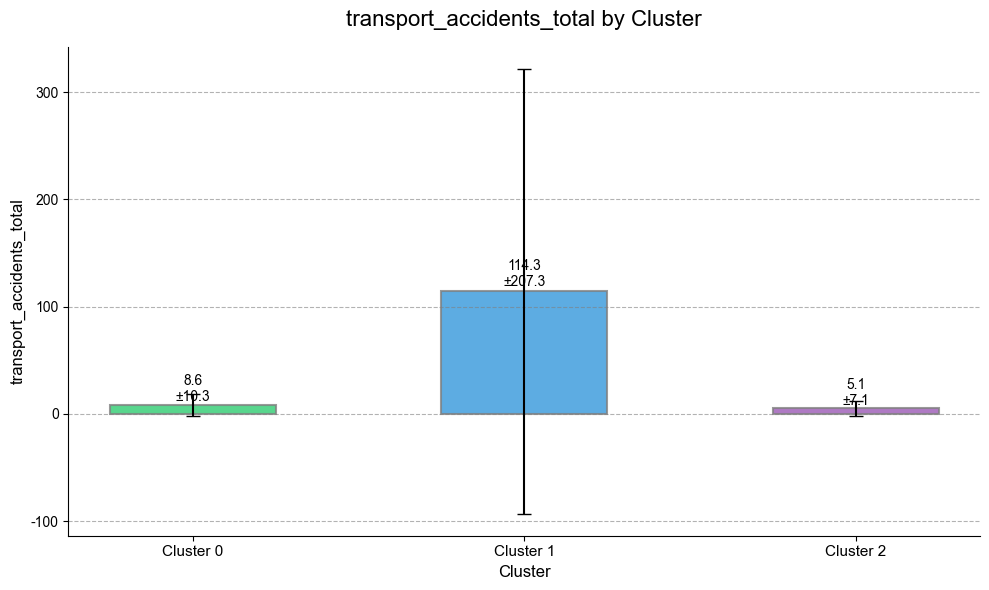


Statistics for transport_accidents_total:
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+
|   cluster_labels_rbf |   count |   mean |    std |   min |   25% |   50% |   75% |   max |
+======================+=========+========+========+=======+=======+=======+=======+=======+
|                    0 |      85 |   8.62 |  10.3  |     0 |     2 |     5 |    12 |    56 |
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+
|                    1 |      65 | 114.29 | 207.3  |     6 |    16 |    44 |   119 |  1199 |
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+
|                    2 |     105 |   5.09 |   7.13 |     0 |     1 |     3 |     7 |    58 |
+----------------------+---------+--------+--------+-------+-------+-------+-------+-------+


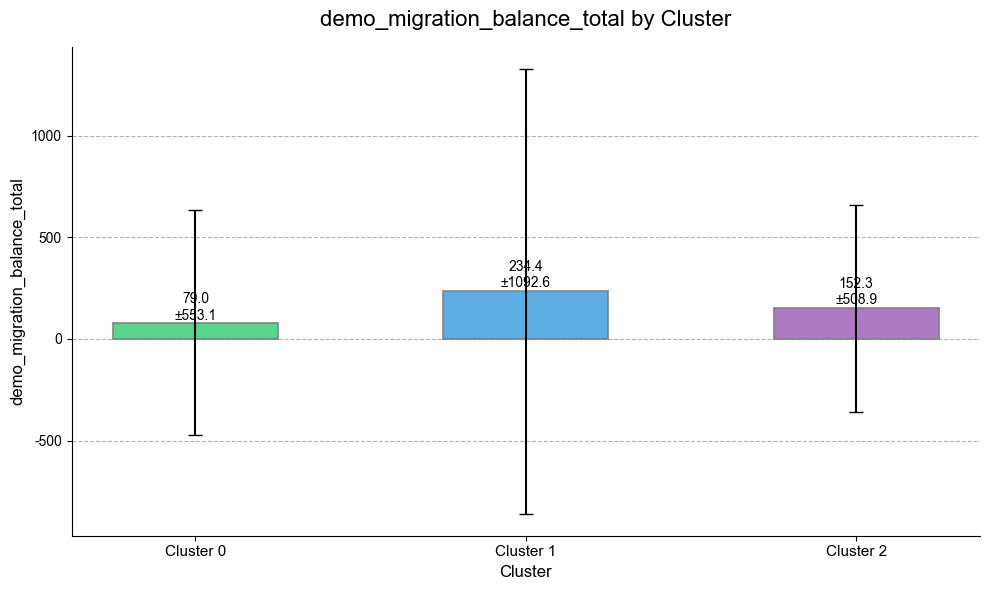


Statistics for demo_migration_balance_total:
+----------------------+---------+--------+---------+-------+-------+-------+-------+-------+
|   cluster_labels_rbf |   count |   mean |     std |   min |   25% |   50% |   75% |   max |
+======================+=========+========+=========+=======+=======+=======+=======+=======+
|                    0 |      85 |  79.04 |  553.13 |  -588 |   -15 |     5 |    34 |  4508 |
+----------------------+---------+--------+---------+-------+-------+-------+-------+-------+
|                    1 |      65 | 234.43 | 1092.56 | -2999 |  -118 |   199 |   620 |  4762 |
+----------------------+---------+--------+---------+-------+-------+-------+-------+-------+
|                    2 |     105 | 152.33 |  508.91 |  -394 |   -51 |    47 |   152 |  3819 |
+----------------------+---------+--------+---------+-------+-------+-------+-------+-------+


In [278]:
analyze_numerical_by_cluster(df, 'cluster_labels_rbf', validated_num_cols)

In this section, we examined the change in salary for each cluster, focusing on the entire population, men, and women.

In [279]:
sal_change=['employ_salary_change_total_pct',
    'employ_salary_change_male_pct', 'emp_salary_change_pct_female']

In [280]:
def plot_cluster_distributions(df, cluster_col, columns_to_plot):

    # Define colors for each type of change
    colors = {
        'general': 'gray',  # Neutral color for general change
        'male': 'blue',     # Blue for male change
        'female': 'pink'    # Pink for female change
    }

    # Ensure cluster labels are categorical
    df[cluster_col] = df[cluster_col].astype('category')

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Create a figure with subplots: 1 row, n columns (one for each cluster)
    fig, axes = plt.subplots(1, len(clusters), figsize=(6 * len(clusters), 5), sharey=True)

    # Plot line charts for each cluster
    for ax, cluster in zip(axes, clusters):
        for col, label, color in zip(columns_to_plot, ['General Change', 'Male Change', 'Female Change'],
                                     [colors['general'], colors['male'], colors['female']]):
            cluster_data = df[df[cluster_col] == cluster][col]
            sns.kdeplot(cluster_data, color=color, label=label, linewidth=2.0, ax=ax)  # Use specific subplot's axis

        # Formatting for each subplot
        ax.set_title(f'Distribution of salary change in Cluster {cluster}', fontsize=14)
        ax.set_xlabel('Change', fontsize=10)
        ax.set_ylabel('Density', fontsize=10 if ax == axes[0] else 0)  # Only the first plot has a y-axis label
        ax.legend(title='Type of Change', fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.show()


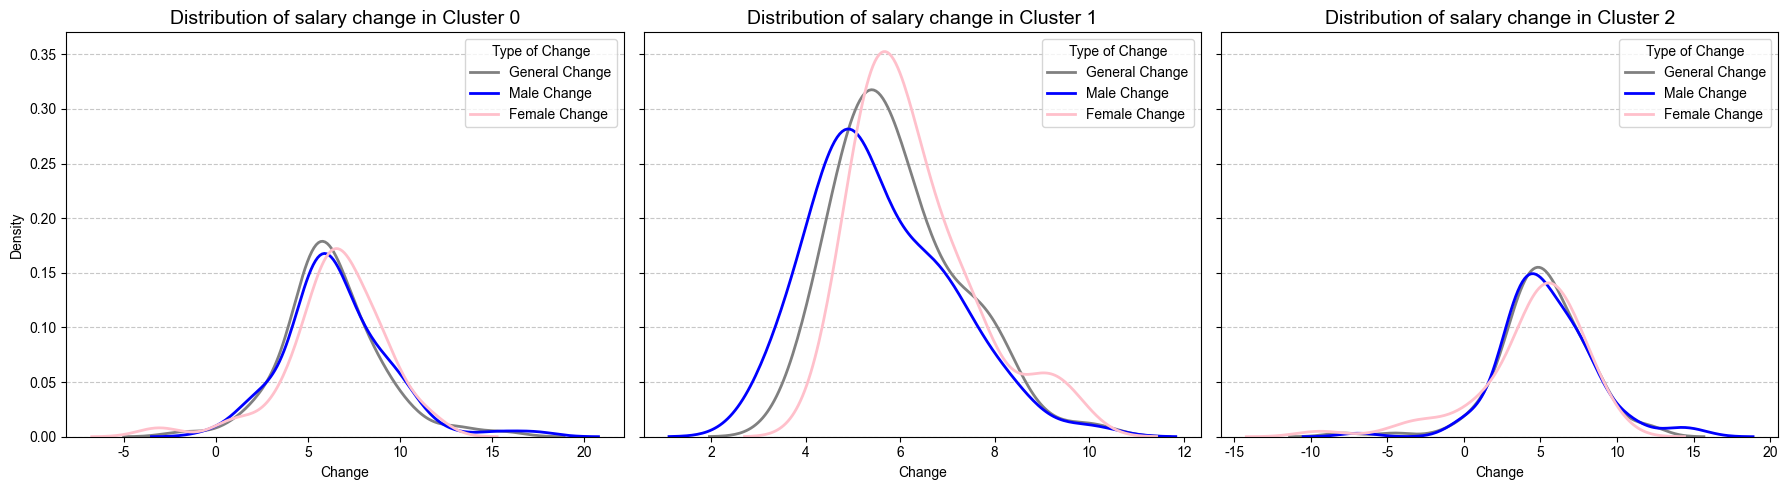

In [281]:
plot_cluster_distributions(df, 'cluster_labels_rbf', sal_change)

### budget

In this section, we examined the budget-to-population ratio in each cluster.  
We explores budget efficiency across authorities by examining the budget-to-population ratio,
which helps identify variations in resource allocation and potential outliers in municipal financial management.

In [282]:
# Calculate the ratio and sort
df['ratio'] = df['budget_total_income'] / df['demo_total_pop']

In [283]:
def create_bar_plot(df, y_column, title=None):
    """
    Create a bar plot with cluster coloring
    """

    # Define colors for clusters
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#f1c40f', '#e74c3c']
    
    # Sort values
    df_sorted = df.sort_values(y_column, ascending=False)
    

    plt.figure(figsize=(15, 8))
    
    # Create bar plot
    bars = plt.bar(range(len(df_sorted)), df_sorted[y_column])
    
    # Color bars based on clusters
    for i, bar in enumerate(bars):
        cluster = df_sorted['cluster_labels_rbf'].iloc[i]
        bar.set_color(colors[cluster])
    
    # Set labels
    plt.xlabel('Authorities', fontsize=12)
    
    # Set title
    if title is None:
        title = f'{y_column} by Authority'
    plt.gca().set_title(title, pad=20)
    
    # Create legend
    unique_clusters = sorted(df_sorted['cluster_labels_rbf'].unique())
    legend_elements = [plt.Rectangle((0,0),1,1, color=colors[c], label=f'Cluster {c}') 
                      for c in unique_clusters]
    plt.legend(handles=legend_elements, title='Clusters')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


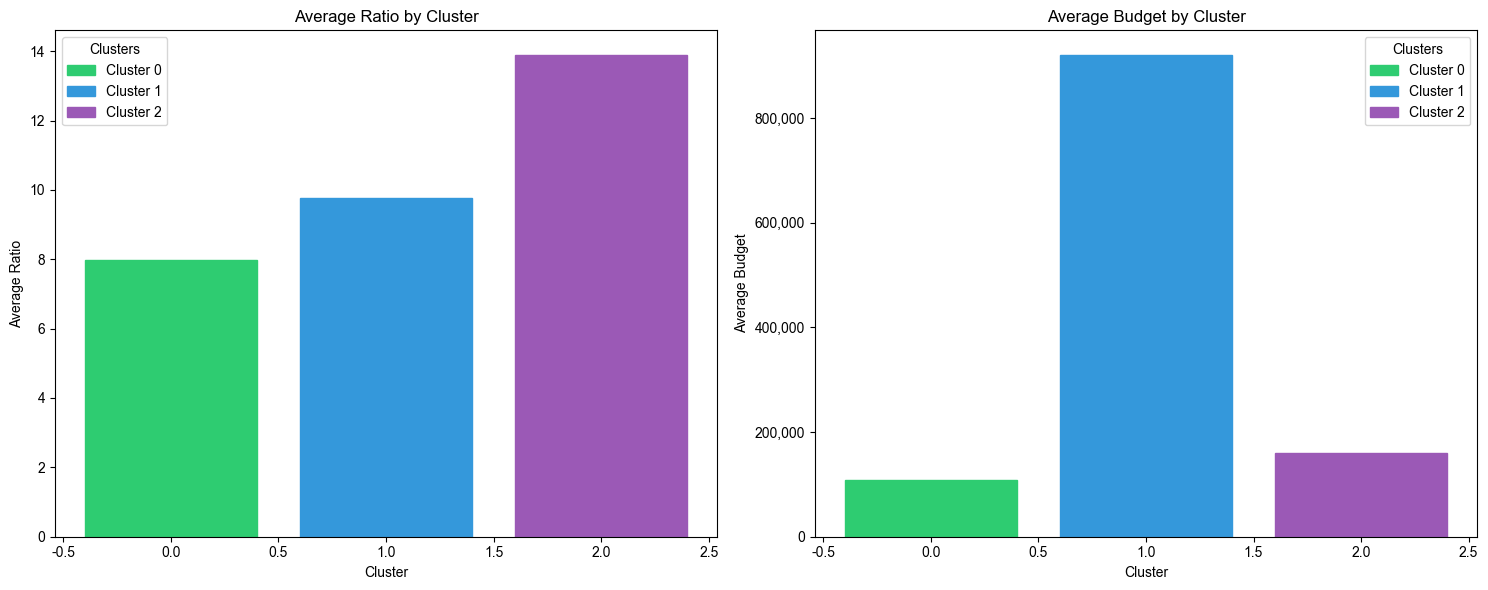


Numerical Values:
  cluster_labels_rbf  ratio  budget_total_income
0                  0   7.98            108213.21
1                  1   9.77            921572.68
2                  2  13.90            160781.30


In [284]:

def plot_cluster_averages(df):
    # Define colors
    colors = ['#2ecc71', '#3498db', '#9b59b6']
    
    # Calculate averages by cluster
    cluster_stats = df.groupby('cluster_labels_rbf').agg({
        'ratio': 'mean',
        'budget_total_income': 'mean'
    }).reset_index()
    
    # Sort by cluster number
    cluster_stats = cluster_stats.sort_values('cluster_labels_rbf')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Create legend elements
    legend_elements = [plt.Rectangle((0,0),1,1, color=colors[i], label=f'Cluster {i}') 
                      for i in range(len(colors))]
    
    # Plot 1: Average Ratio
    bars1 = ax1.bar(cluster_stats['cluster_labels_rbf'], 
                    cluster_stats['ratio'])
    
    # Color bars and set properties for first plot
    for i, bar in enumerate(bars1):
        bar.set_color(colors[i])
    ax1.set_title('Average Ratio by Cluster')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Average Ratio')
    ax1.legend(handles=legend_elements, title='Clusters')
    
    # Plot 2: Average Budget
    bars2 = ax2.bar(cluster_stats['cluster_labels_rbf'], 
                    cluster_stats['budget_total_income'])
    
    # Color bars and set properties for second plot
    for i, bar in enumerate(bars2):
        bar.set_color(colors[i])
    ax2.set_title('Average Budget by Cluster')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Average Budget')
    ax2.legend(handles=legend_elements, title='Clusters')
    
    # Format y-axis for budget to show millions
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plots
    plt.show()
    
    # Print numerical values
    print("\nNumerical Values:")
    print(cluster_stats.round(2))

# Example usage:
plot_cluster_averages(df)

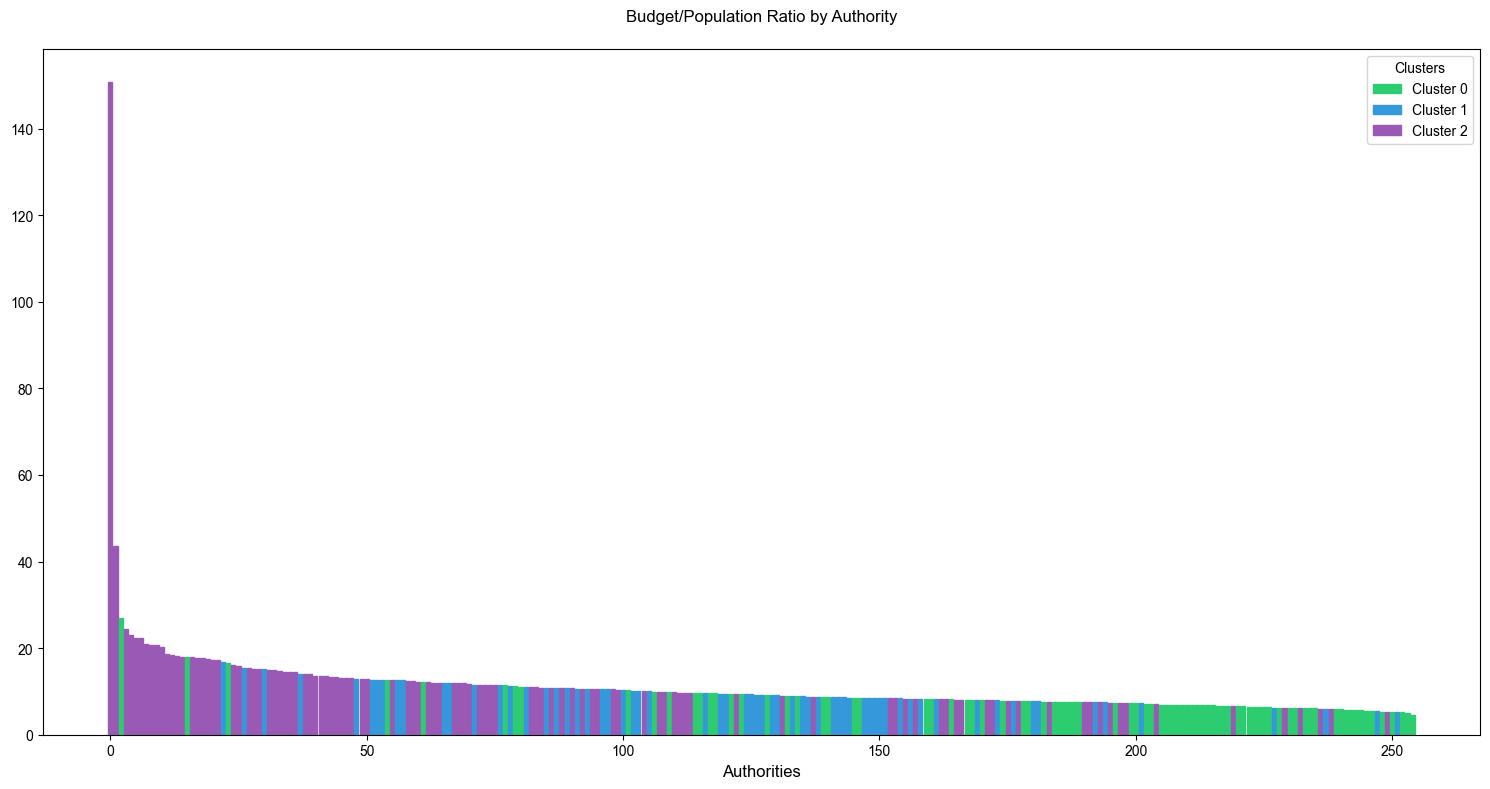

In [285]:
# For ratio plot
create_bar_plot(df, 'ratio', 'Budget/Population Ratio by Authority')

In [286]:
df[df['ratio']>100]

,auth_name,authority_code,authority_status,budget_total_income,budget_reg_inc_total,budget_reg_inc_per_capita,budget_reg_inc_tax_grants,budget_reg_inc_local_services,budget_reg_inc_gov_services_total,budget_reg_inc_gov_education,...,Municipal Status,Settlement Religion,Current Settlement Form,Coordinates,Average Elevation,Planning Committee,Police Jurisdiction,English Settlement Name,cluster_labels_rbf,ratio
45,תמר,51,מועצה אזורית,227660,161088,106751.491054,124640,11715,10219,9090,...,99,יהודי,190,2.067224e+09,138.5,354,10004315,Tamar,2,150.868125


The Tamar Regional Council emerged as an outlier whith 'ratio' > 100  
with the highest budget-to-population ratio. This can be attributed to the substantial   
tourism revenue generated from the Dead Sea region, which significantly impacts the   
council's budget despite its relatively small permanent population.  

## **Conclusion**

### Cluster 0:
Peripheral, Rural Areas with Predominantly Arab Municipalities
- Characteristics: Farthest from Tel Aviv (88.8 km), small populations (15,035), and limited land area (9 km²).
Mainly Arab municipalities (95.3%).
- Challenges: Low migration balance (negative), limited infrastructure, and the lowest budget per capita (₪7.98).

### Cluster 1: 
Urban and Semi-Central Municipalities with Mixed Populations
- Characteristics: Moderate distance from Tel Aviv (52.2 km), large populations (94,923), and urbanized areas (26.7 km²). Includes 87.7% Jewish and 12.3% mixed municipalities.
- Challenges: High road accident rates, economic disparities within cities.
- Strengths: Positive migration balance (234.4), highest total budget (₪921,573), and strong education systems.

### Cluster 2: 
Stable, Centrally Located, Jewish-Only Municipalities
- Characteristics: Closest to Tel Aviv (29.7 km), mid-sized but stable populations (13,877), and large land areas (174.3 km²). All municipalities are Jewish.
- Strengths: Highest budget per capita (₪12.59), indicating abundant resources and stability.

-------------
For full documentation and methodology details, please refer to README.md